# Boundary Visualization
### 11/3/20
### B6 included
### Comparing aggregated keypresses to putative event boundaries

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
%autosave 5

Autosaving every 5 seconds


# I. Setup
### i. Import data

In [2]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/parsing_log_file/pickle/data_dict_pilots_b1_b2_b3_b4_b5_b6.p'
data_dict = pickle.load( open( filename, "rb" ) )

### ii. import and organize story files
#### a. Import file

In [3]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/fMRI experiment/1:8:2020_edited_stories'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

#### b. organize putative event boundaries

In [4]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

### iii. Exclusions
#### a. exclude participants who only pressed '1' or '9' (not including first row 10/14)

In [5]:
keys_to_del = []
for key in data_dict:
    kp = data_dict[key]['story_presses']
    kp_i = kp.iloc[1:]
    check_kp_i = len(set(kp_i))
    if check_kp_i == 1:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_12h52.50.131
5cf0a300b094d700183e4d54
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot3/4/PARTICIPANT_1_online_exp_2020-05-20_17h03.06.828
5d82994758861000188f76dc
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/23_1_online_exp_2020-06-09_13h39.42.955
5bd9fed6780d50000109c503
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/145_1_online_exp_2020-06-10_15h14.14.911
5ec18c4c2f44695b38204649
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/171_1_online_exp_2020-06-10_21h32.27.534
5de12fbfe4f42a1842172d7a
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/33_1_online_exp_2020-06-10_21h03.35.215
5ecfb797dc64e1028cc510ba
/Users/alexreblando/Documents/GitHub/data_ana

#### b. Exclude participants who don't answer short answers

In [6]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/73_1_online_exp_2020-06-10_14h37.05.252']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/199_1_online_exp_2020-06-24_20h41.05.680']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/345_1_online_exp_2020-07-16_09h07.09.087']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b6/76/39_1_online_exp_2020-10-20_13h05.53.446']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b6/76/31_1_online_exp_2020-10-20_11h38.47.446']

#### c. exclude participant w no data

In [7]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b6/76/6_1_online_exp_2020-10-20_10h04.26.275']

#### c. Exclude participants who said said more than half the sentences were a boundary

In [8]:
keys_to_del = []

for key in data_dict:
    kp = data_dict[key]['story_presses']
    N_kp= np.sum(kp == 9)
    this_story = data_dict[key]['story'].iloc[0]
    half_story_len = np.rint(len(story_boundaries[this_story])/2)
    if N_kp >= half_story_len:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_20h42.51.597
5ce5b9844cd8130019acba32
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot4/7/PARTICIPANT_1_online_exp_2020-05-27_21h05.22.618
5d46c556fb0ce0001a04fd01
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/18_1_online_exp_2020-06-06_14h58.27.858
571ceeb64ca277000953d1c1
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/21_1_online_exp_2020-06-06_15h20.03.392
5eda9f7c460b766ded73bdb7
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/24_1_online_exp_2020-06-09_20h39.35.048
5ea616a090d52b61615dfb3b
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/152_1_online_exp_2020-06-10_21h15.29.074
5d331b4c9ce6590019010930
/Users/alexreblando/Documents/GitHub/data_analys

#### d. Pickle data_dict in order to get group counts

In [9]:
pickle.dump( data_dict, open( 'check', "wb" ) )

# II. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [10]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [11]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [12]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [13]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

## D. Remove first sentence (first row) from all a priori story boundaries

In [14]:
for key in story_boundaries:
    story_boundaries[key] = np.delete(story_boundaries[key],(0), axis = 0)

# III. Aggregating all participants regardless of priming
## A. Compare aggregated keypresses to location boundaries

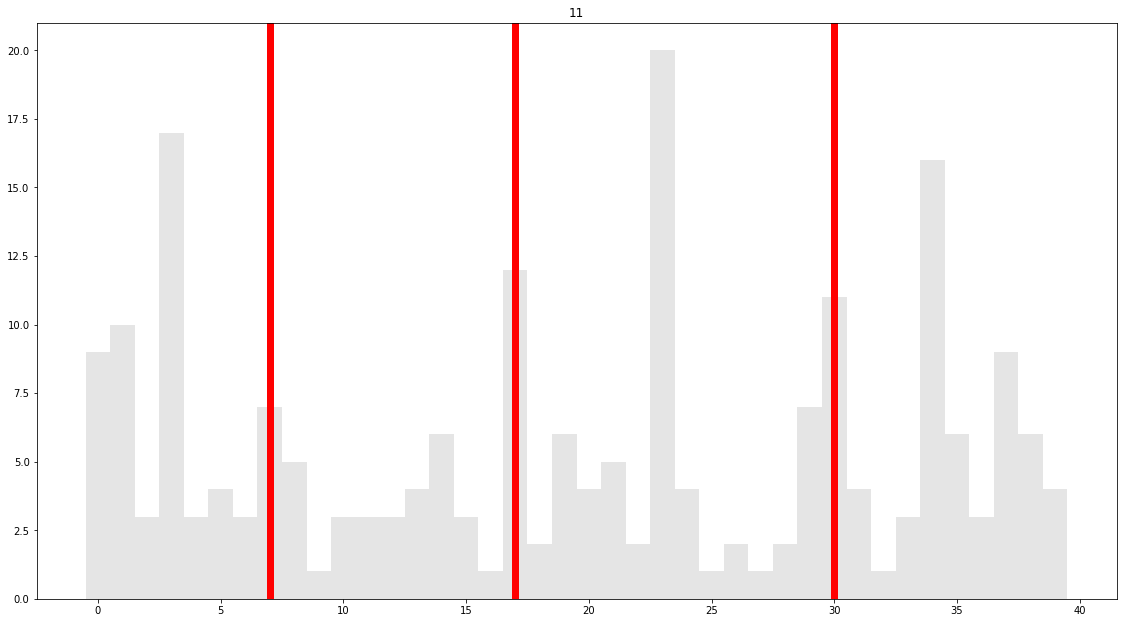

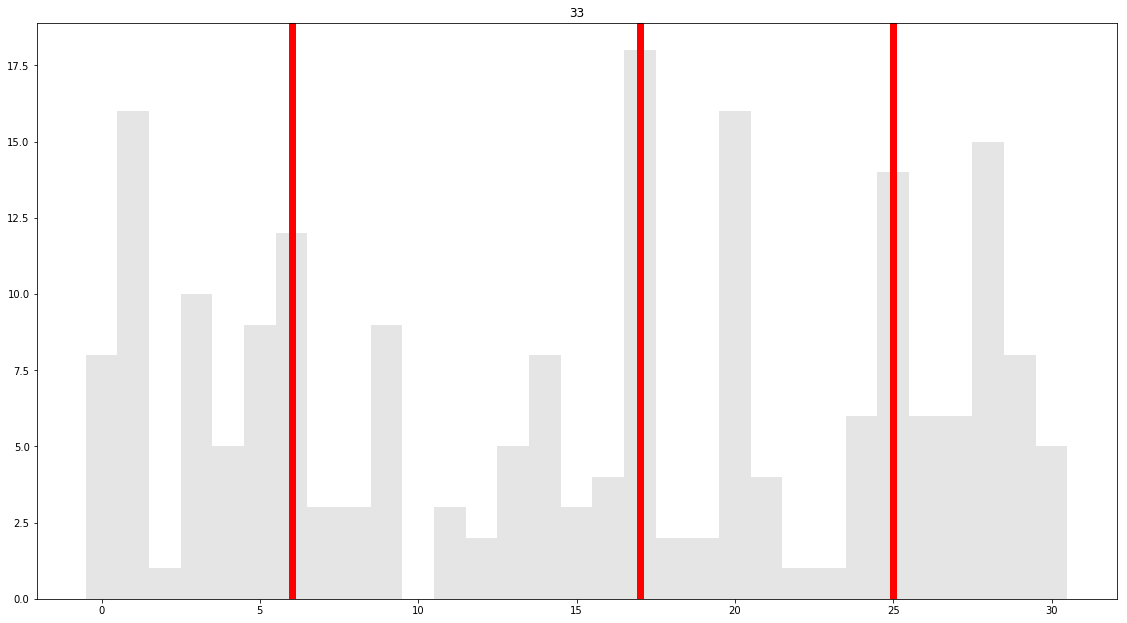

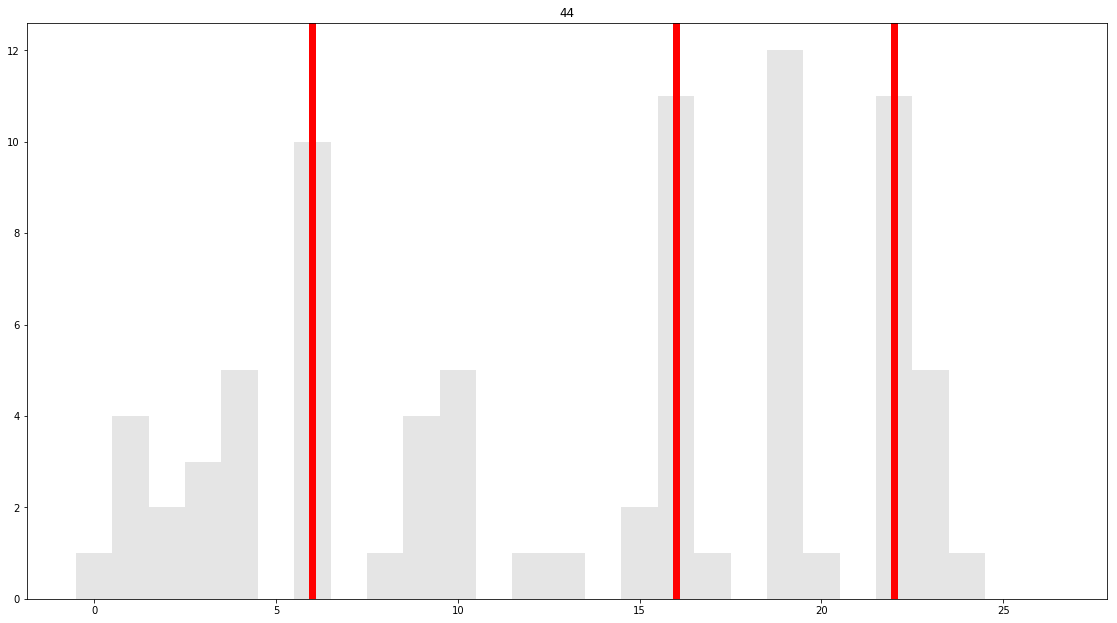

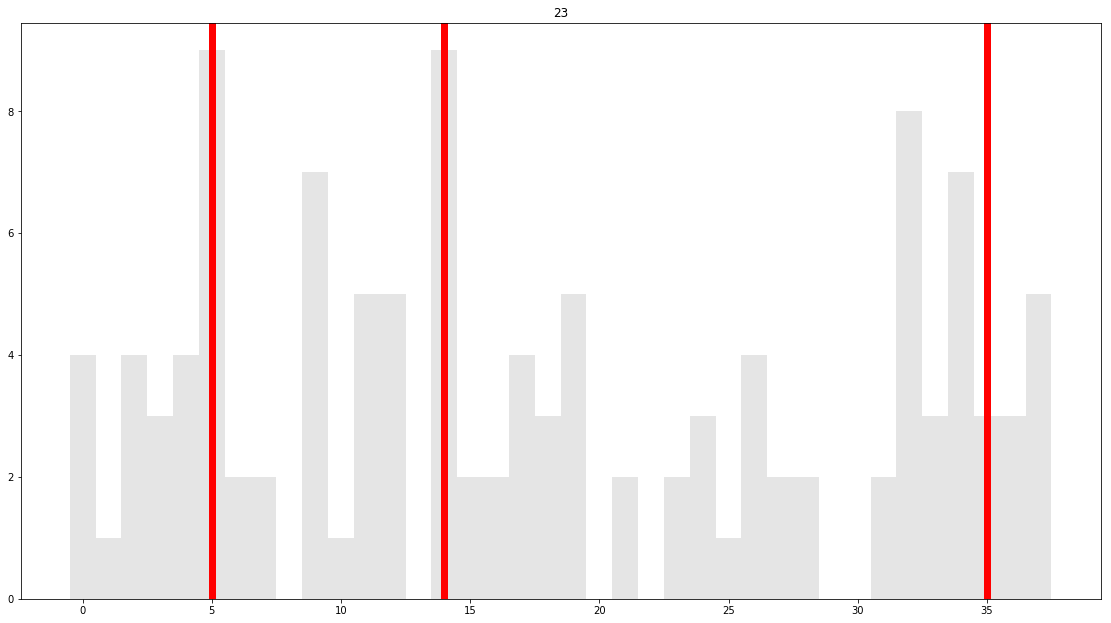

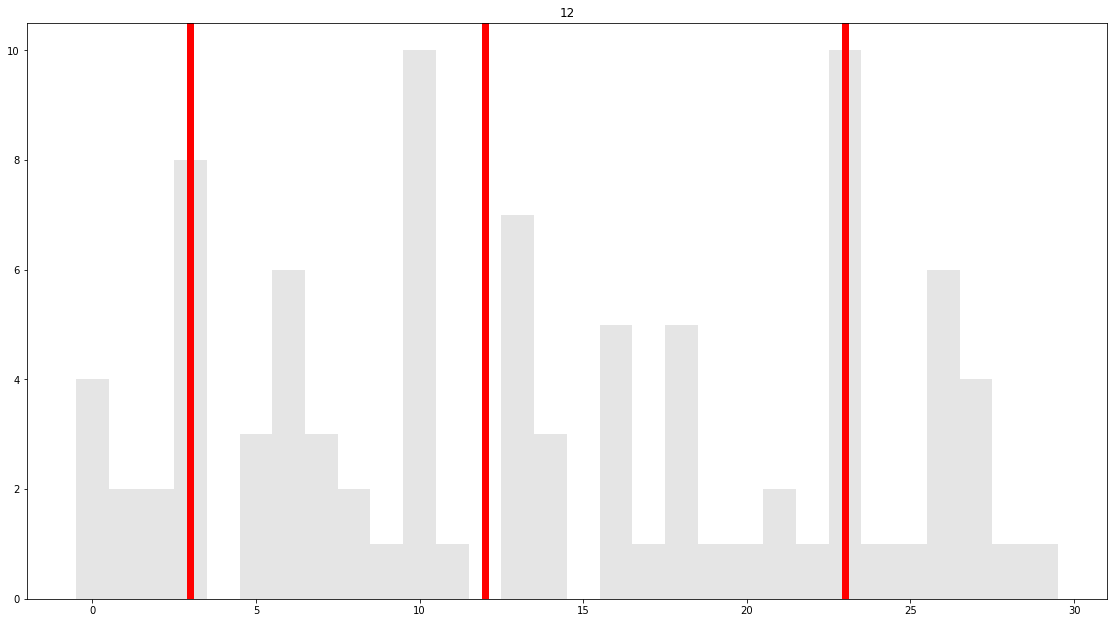

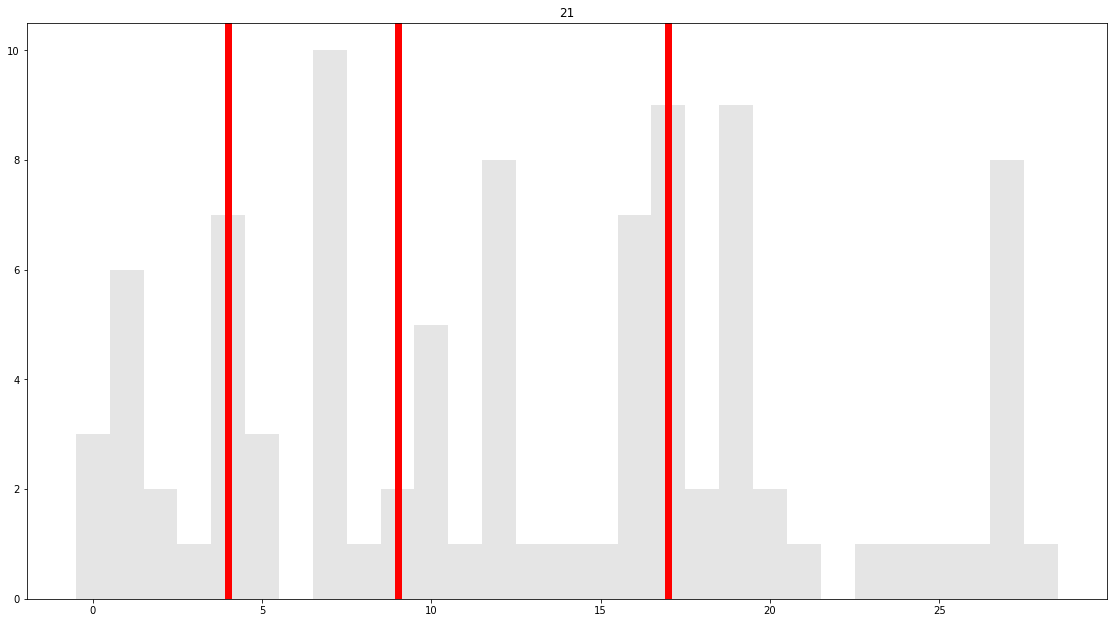

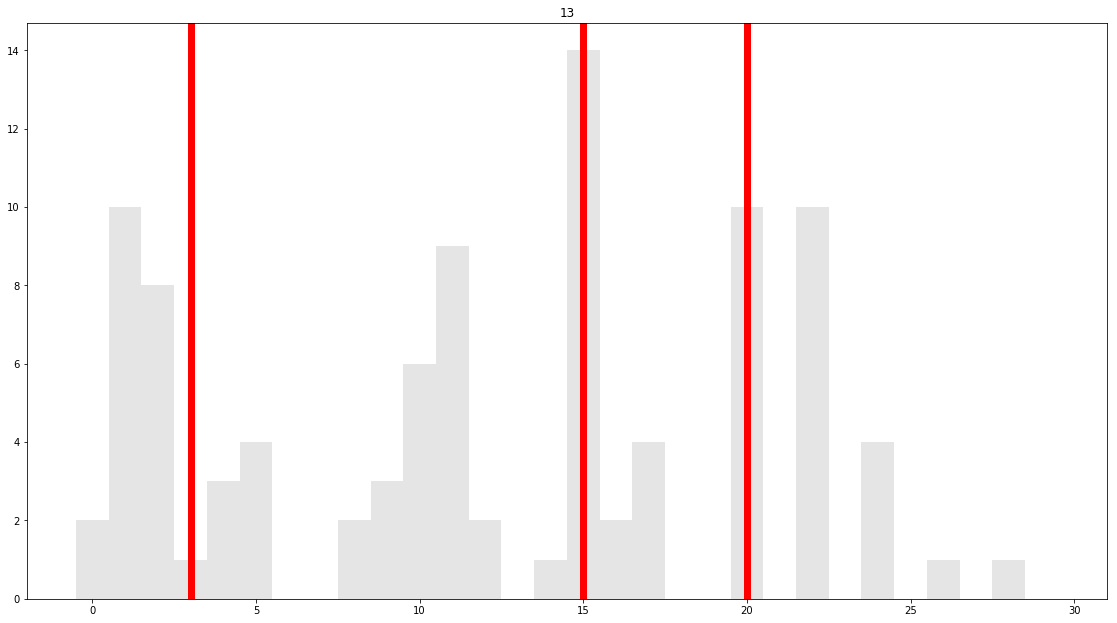

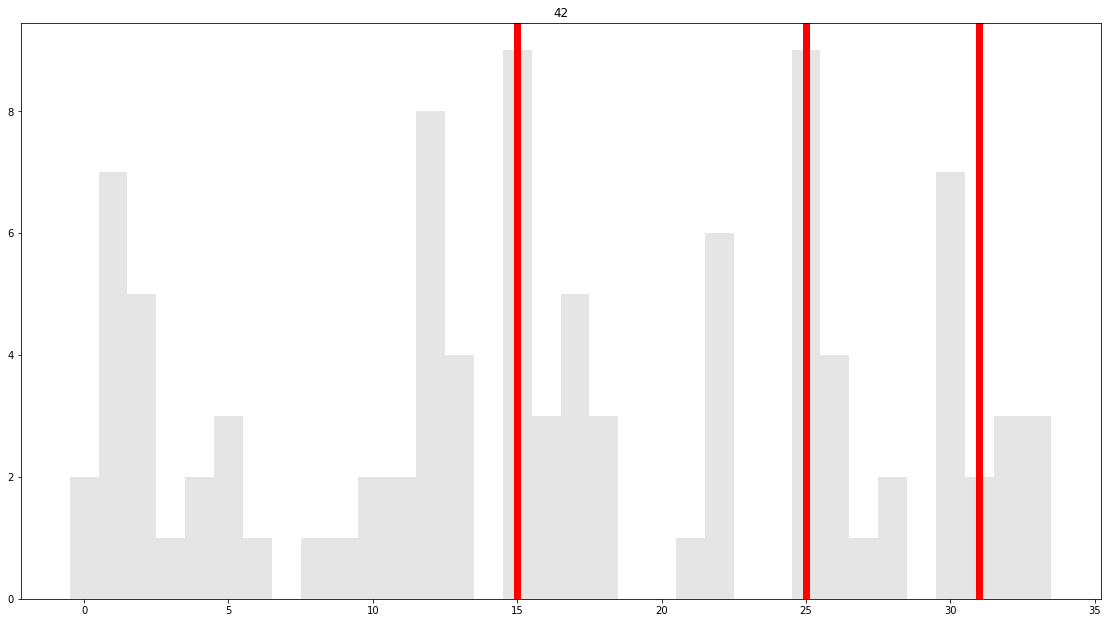

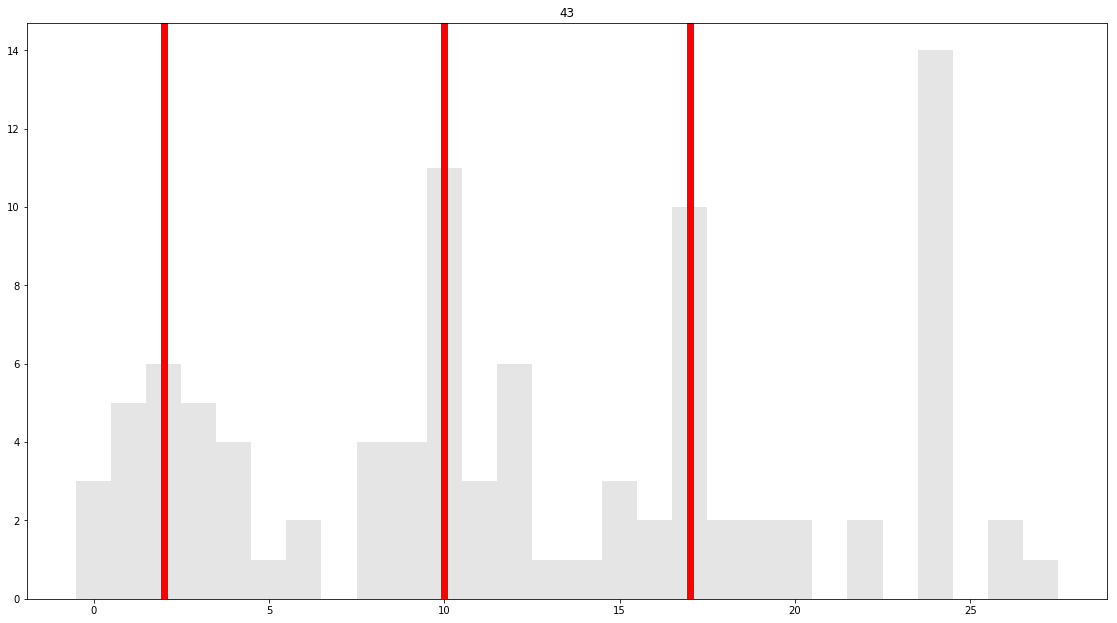

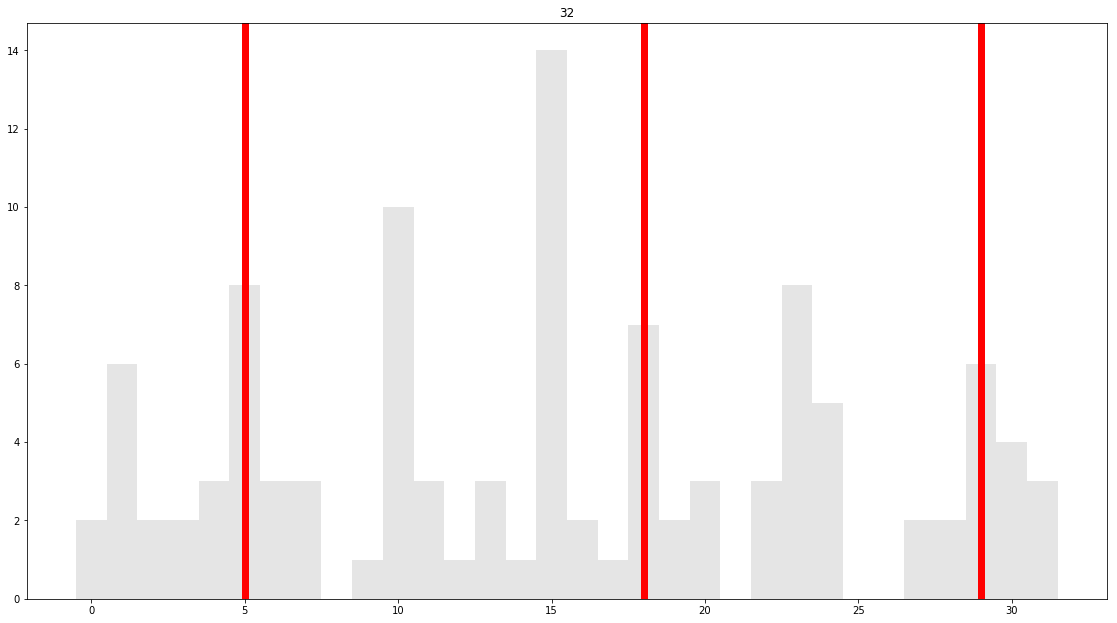

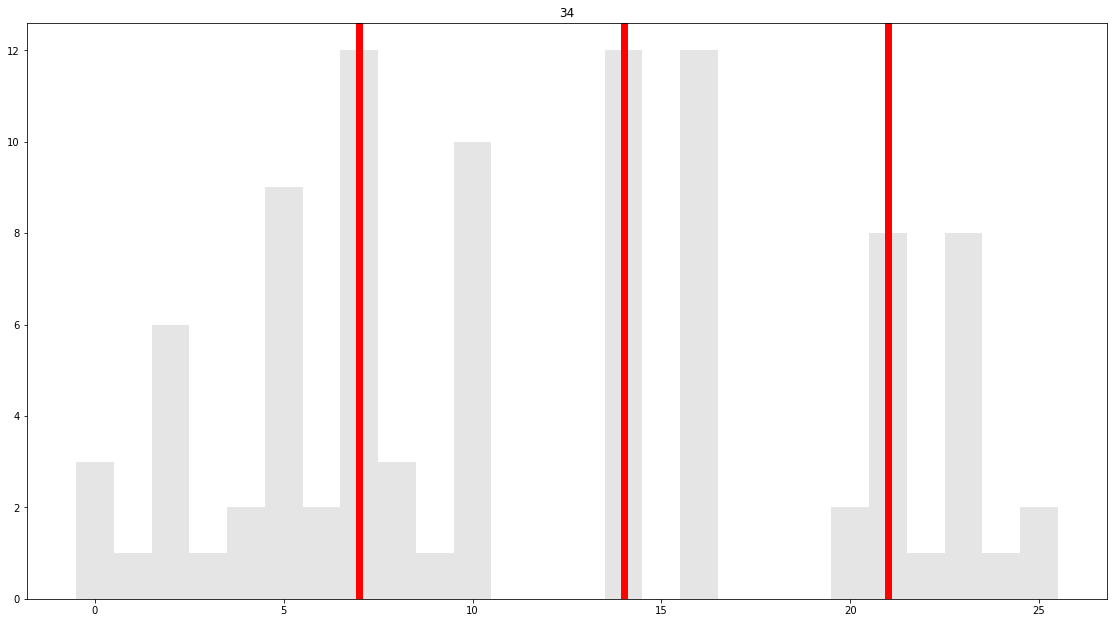

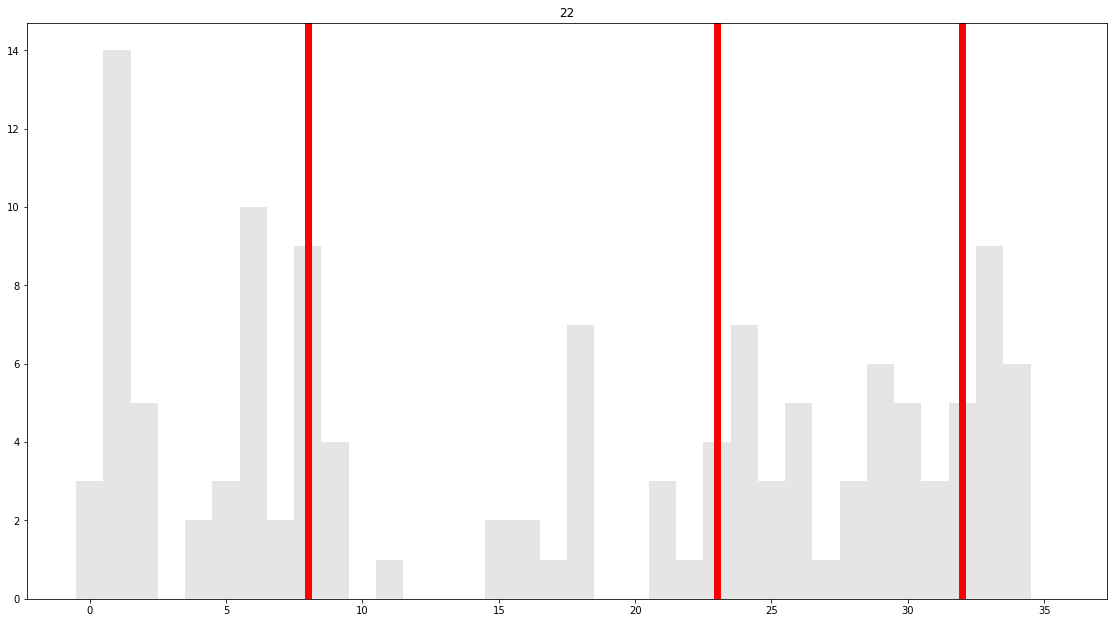

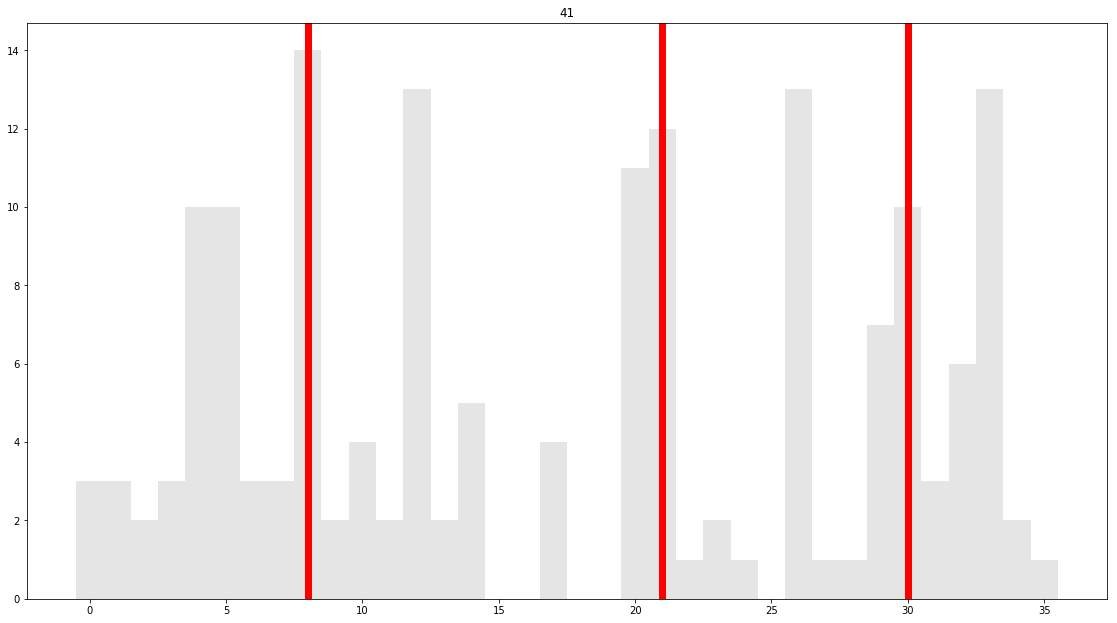

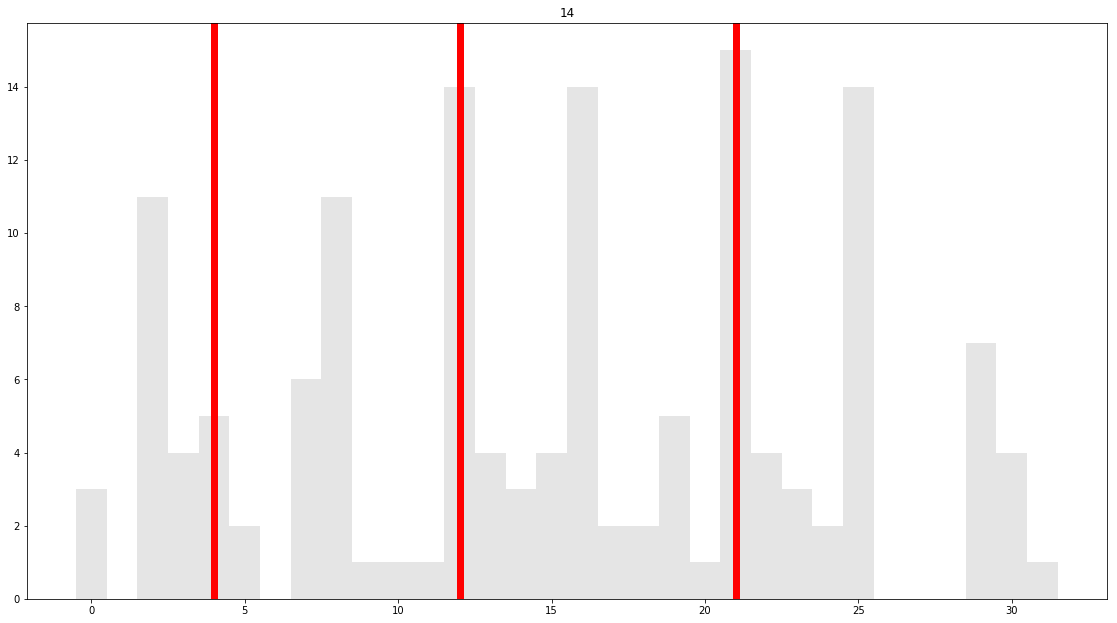

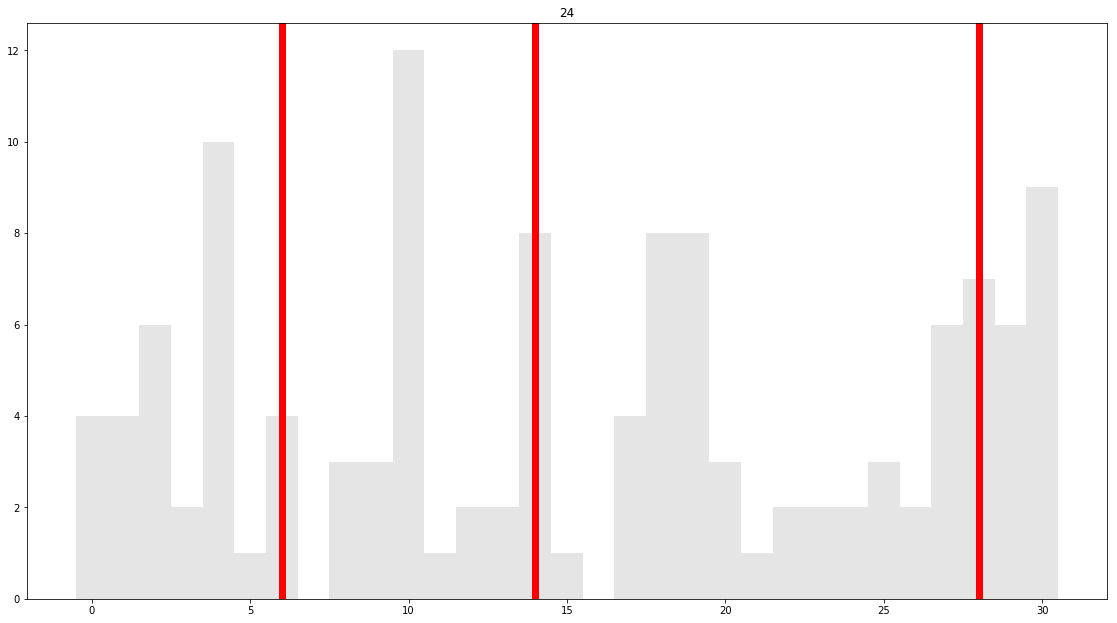

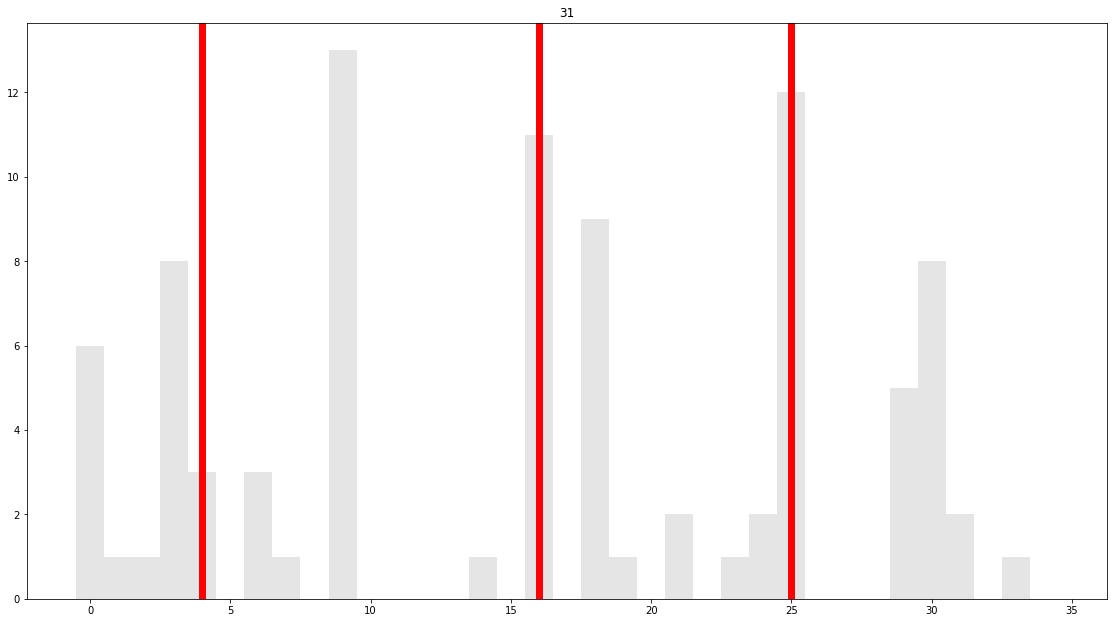

In [15]:
# Instantiating new dict and iterating through all_keys summing along row-wise
sum_keys = {}

for key in all_keys:
    these_keys = all_keys[key]
    sum_keys[key] = np.sum(these_keys, axis = 1)

# Plot each sum_keys array with loc boundaries
for key in sum_keys:
    X = np.arange(len(sum_keys[key]))
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X, sum_keys[key], color = 'k', width = 1 , alpha=0.1)
    ax.set_title(key)
    # Plotting the location boundaries
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = 'r', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = 'r', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = 'r', linewidth=7.0)

## B. Compare aggregated keypresses to social boundaries

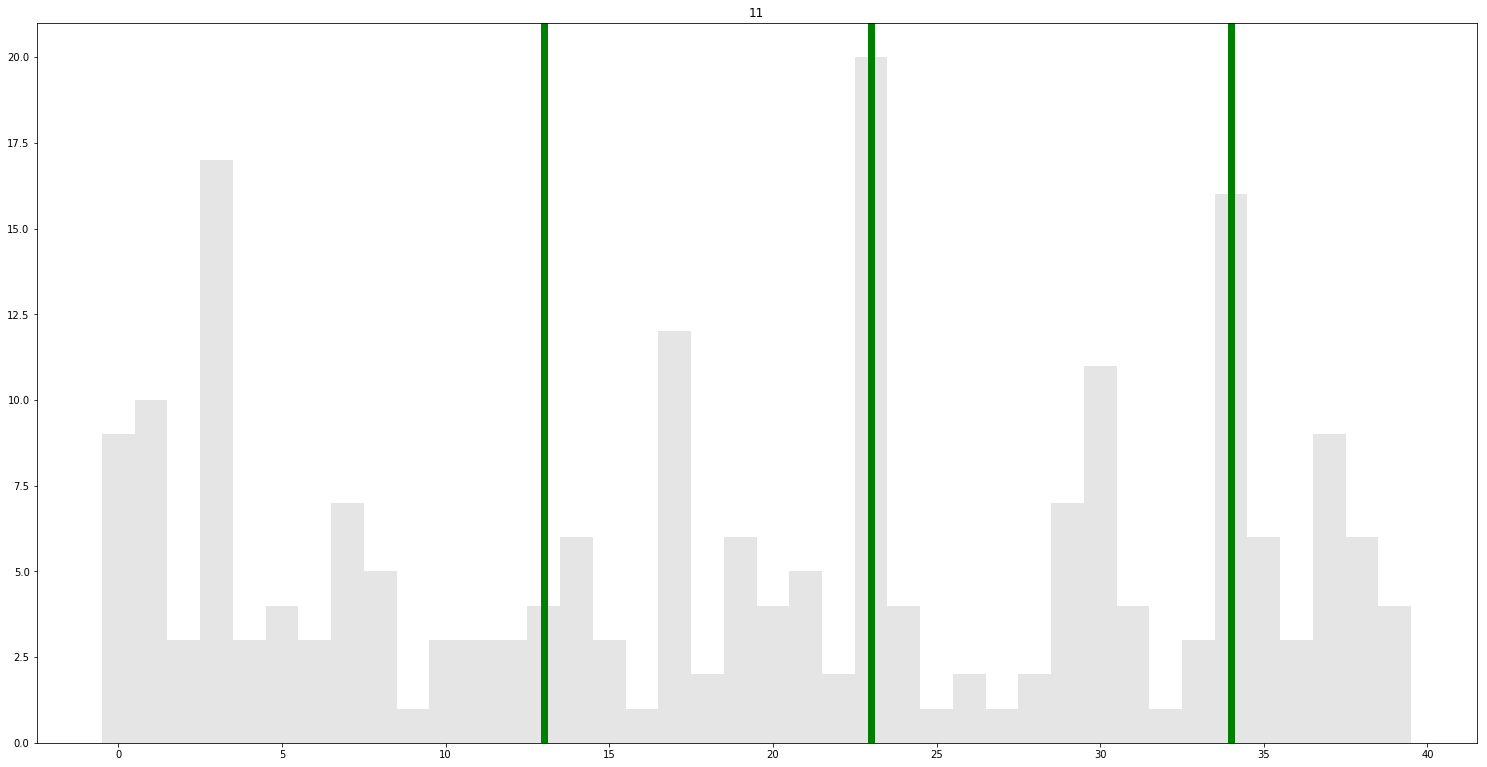

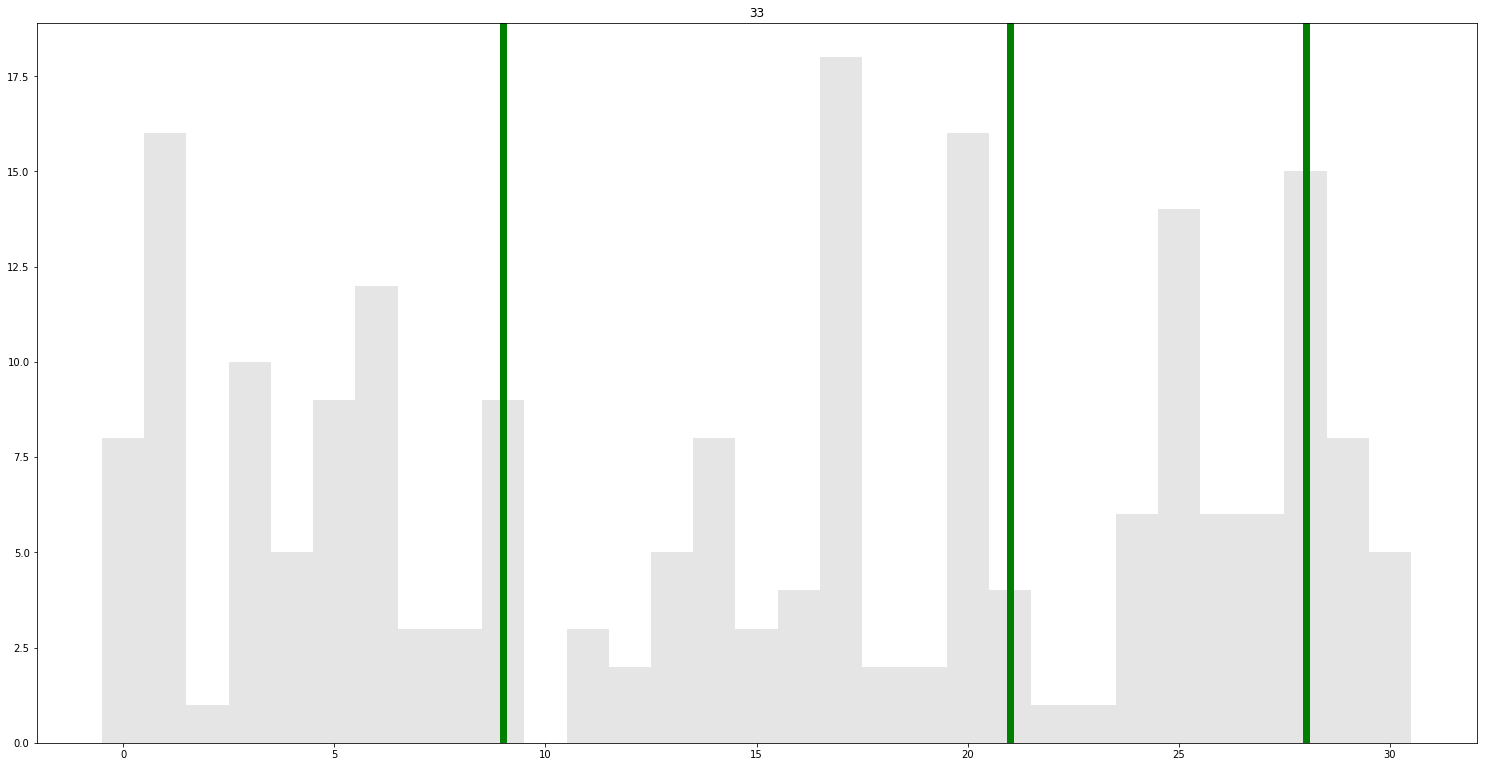

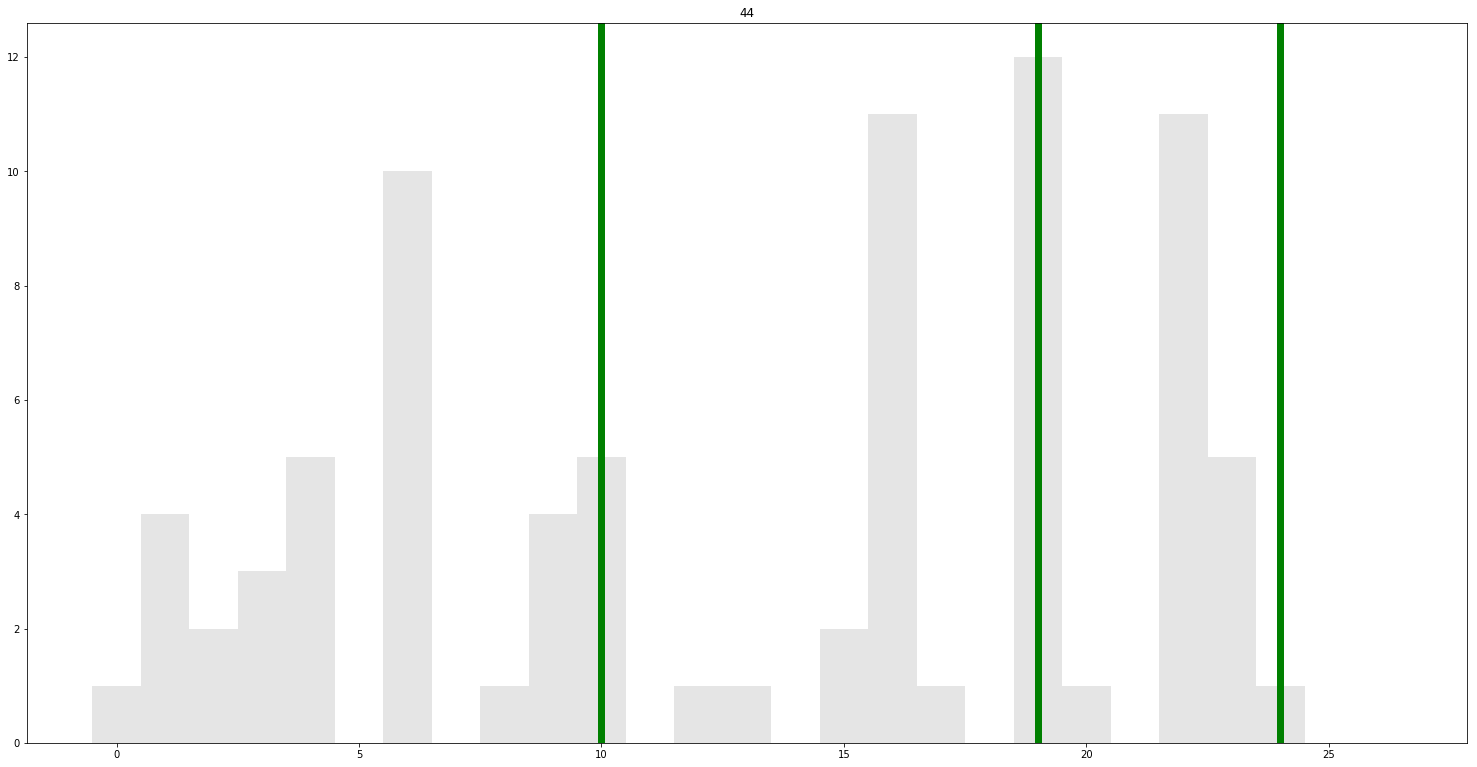

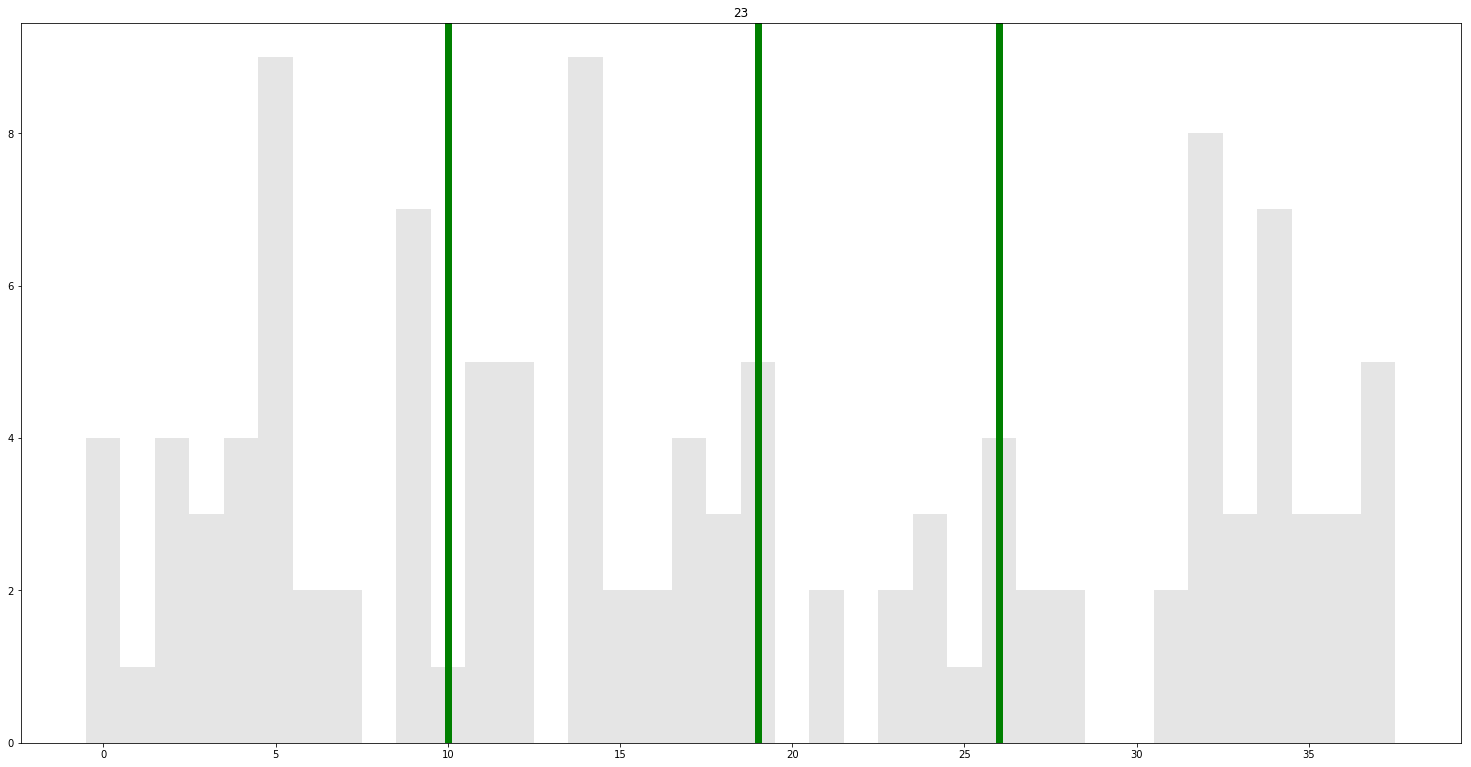

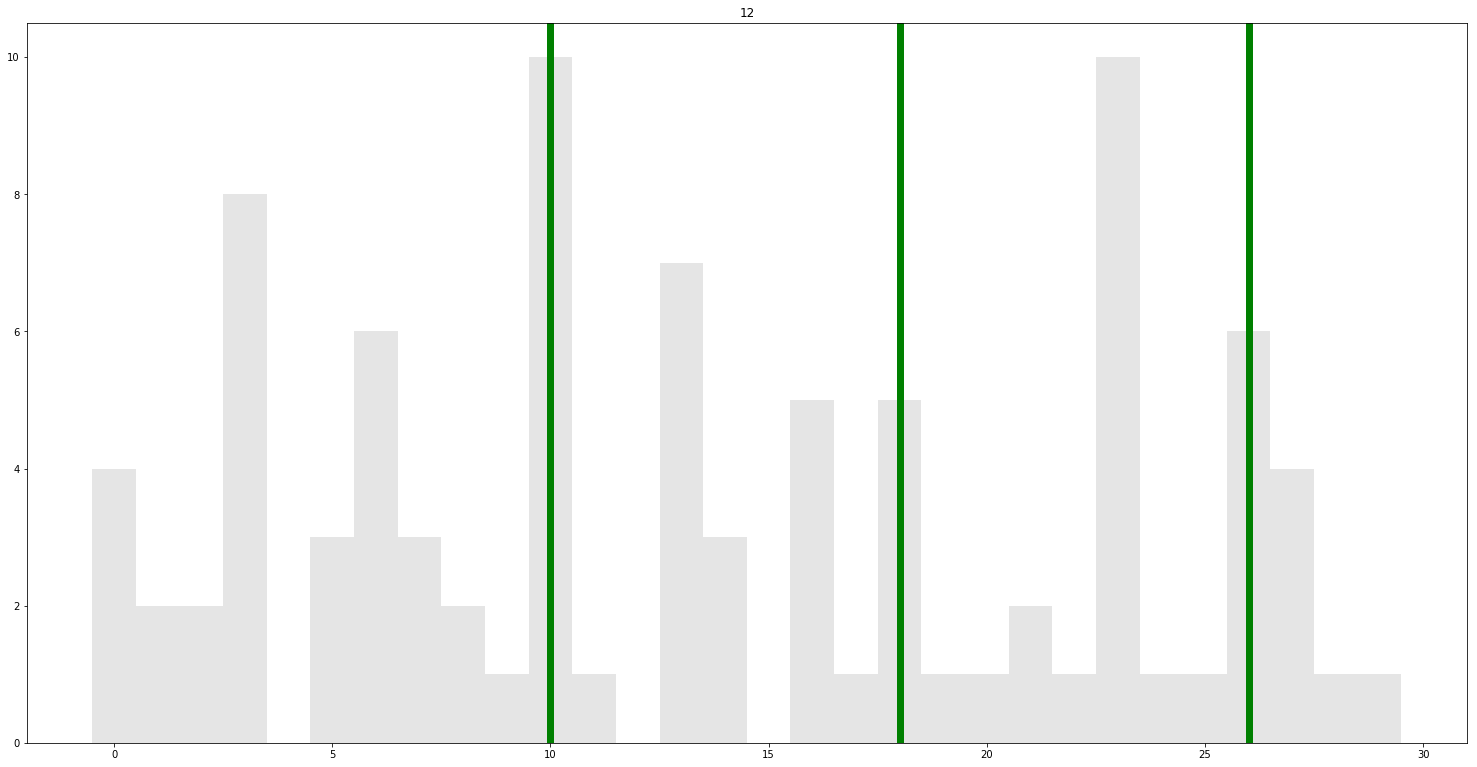

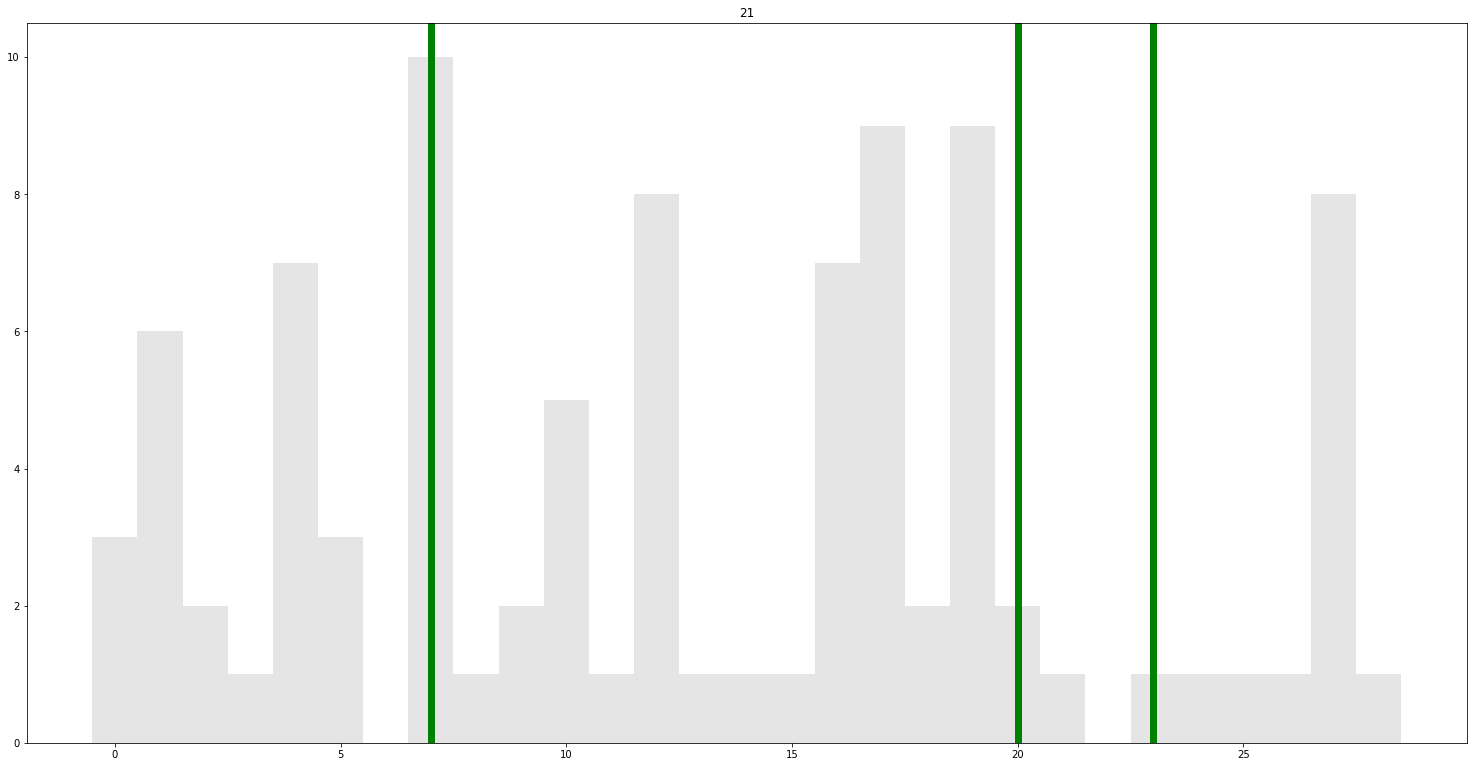

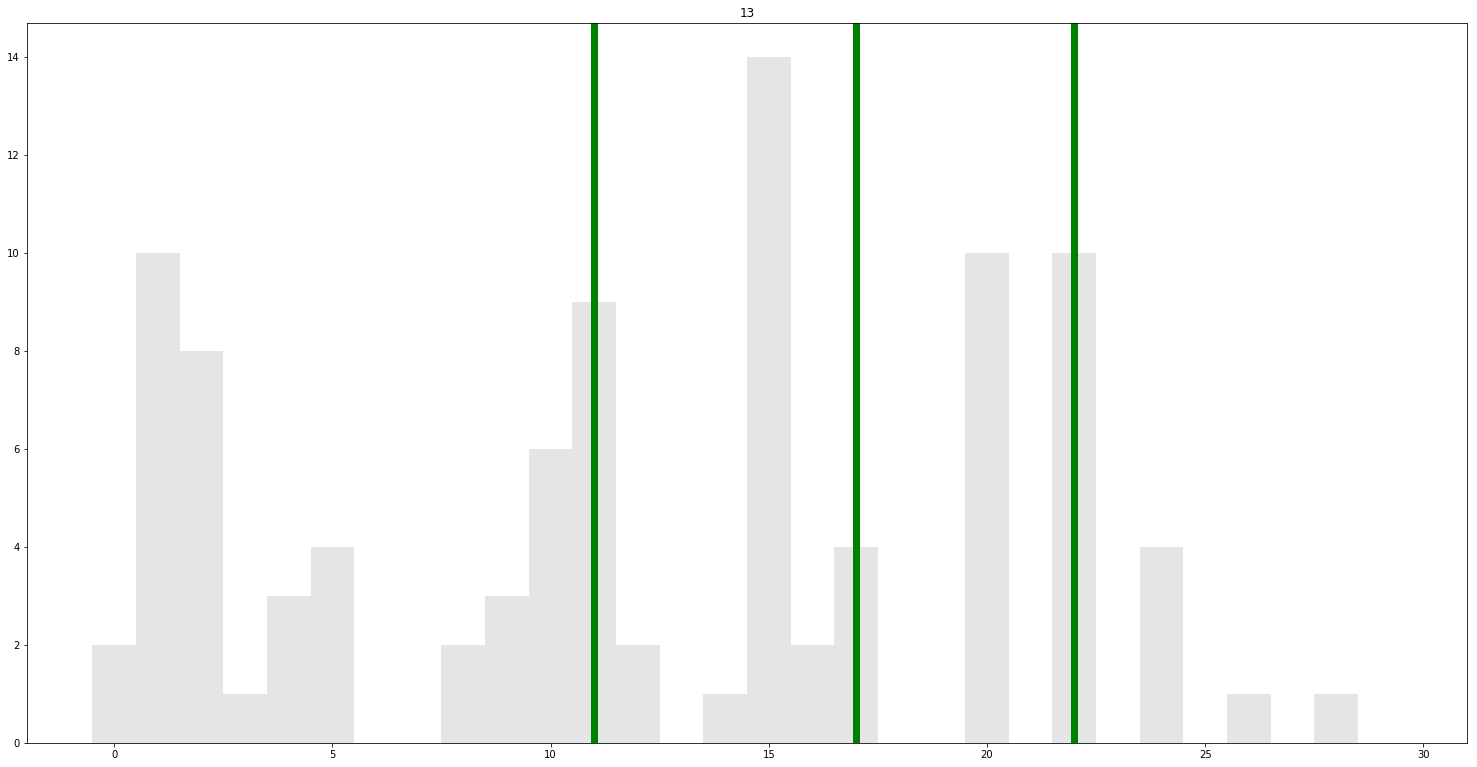

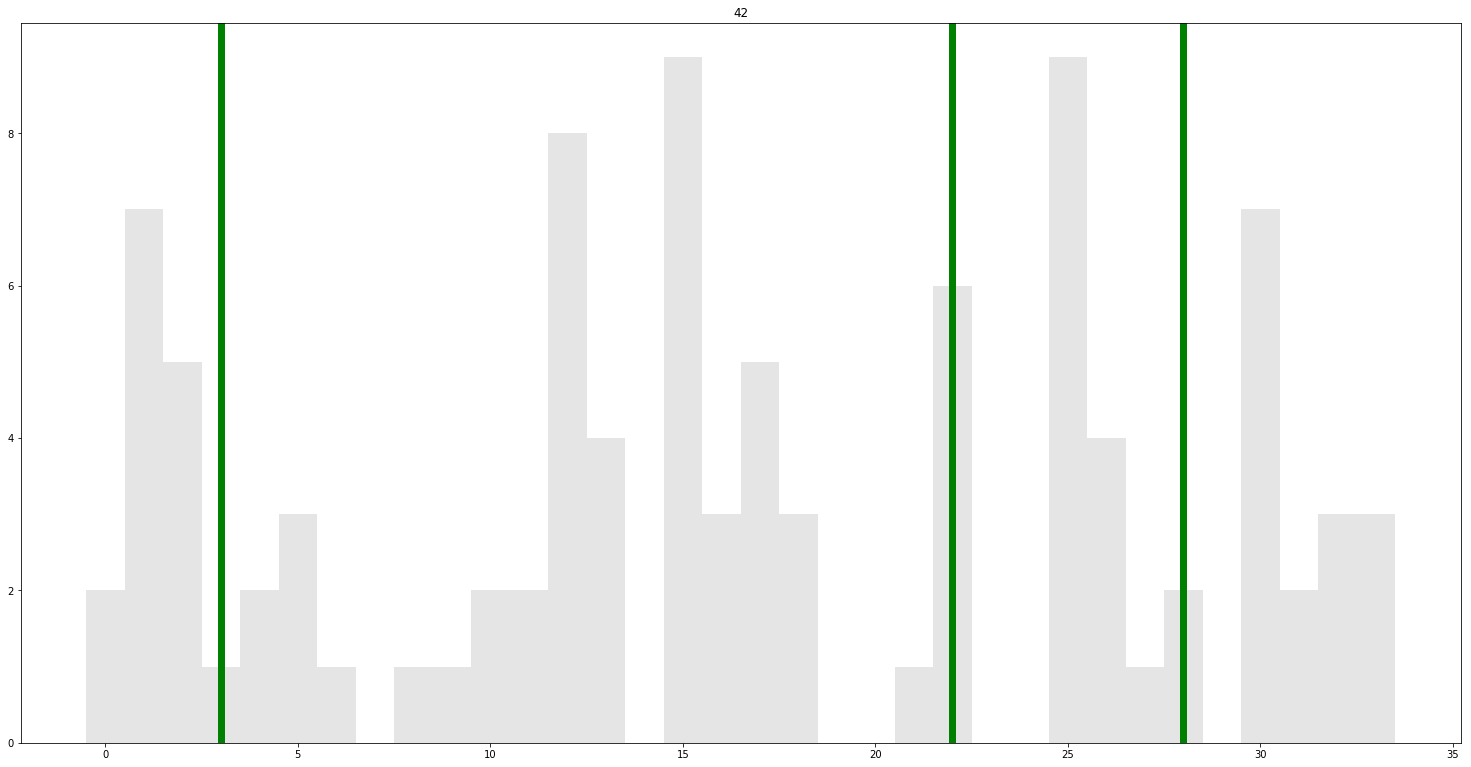

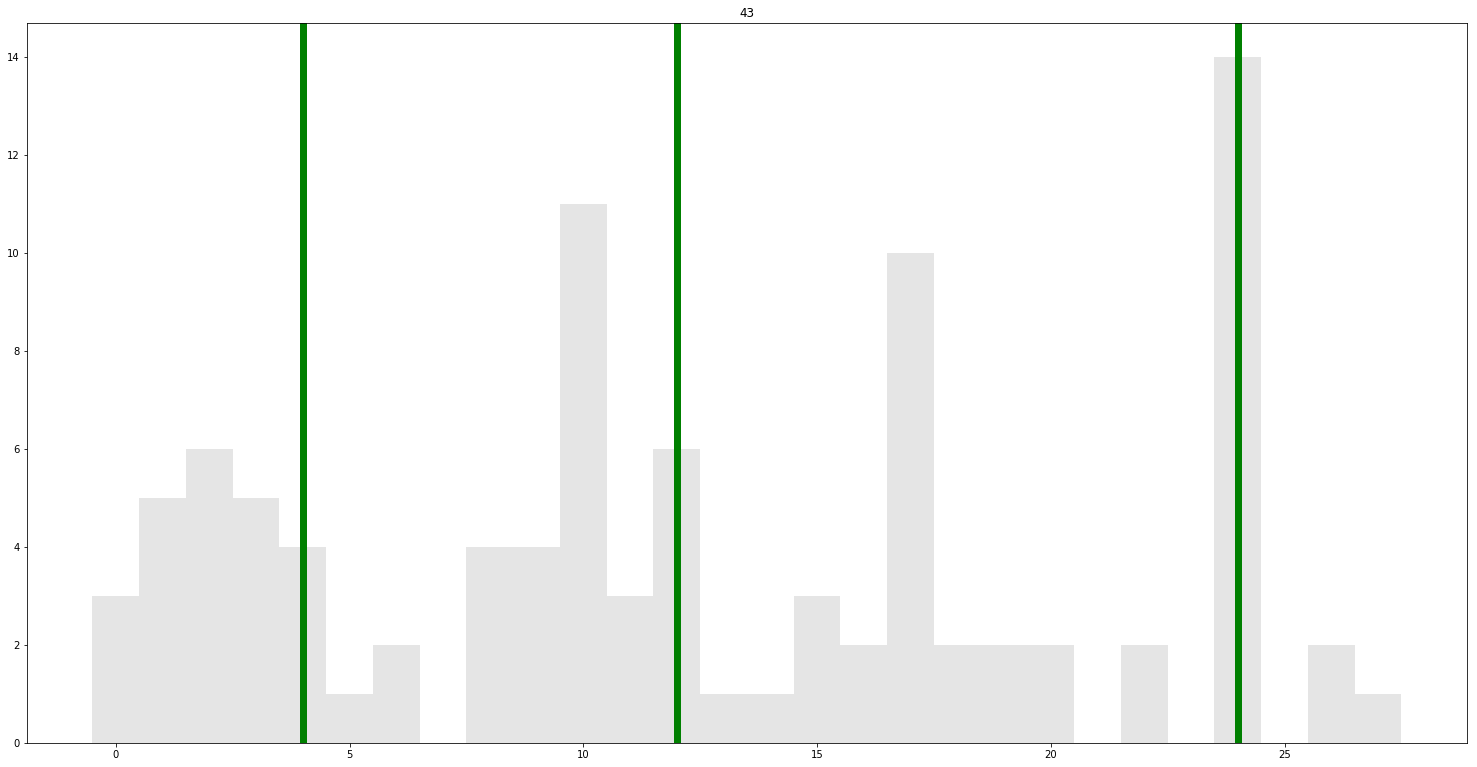

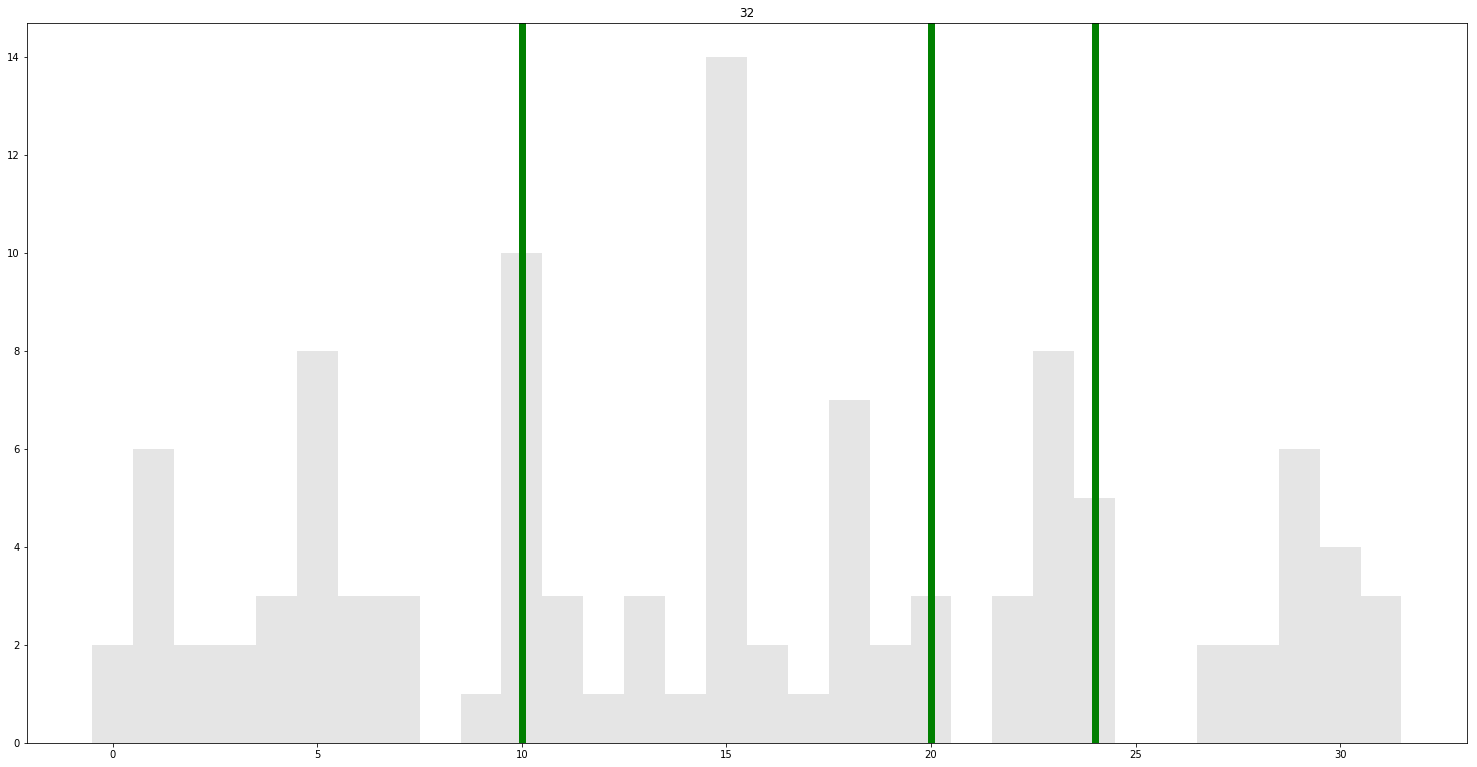

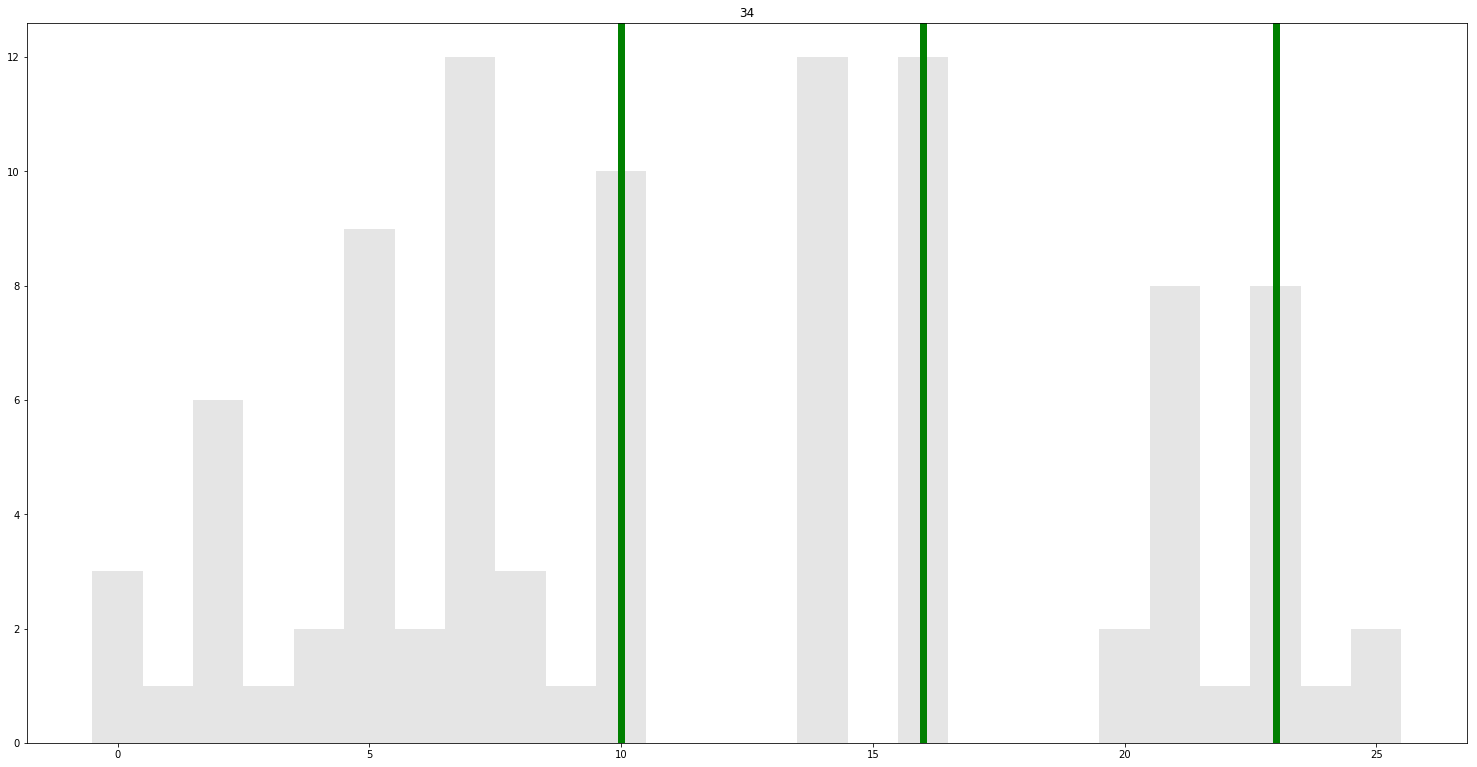

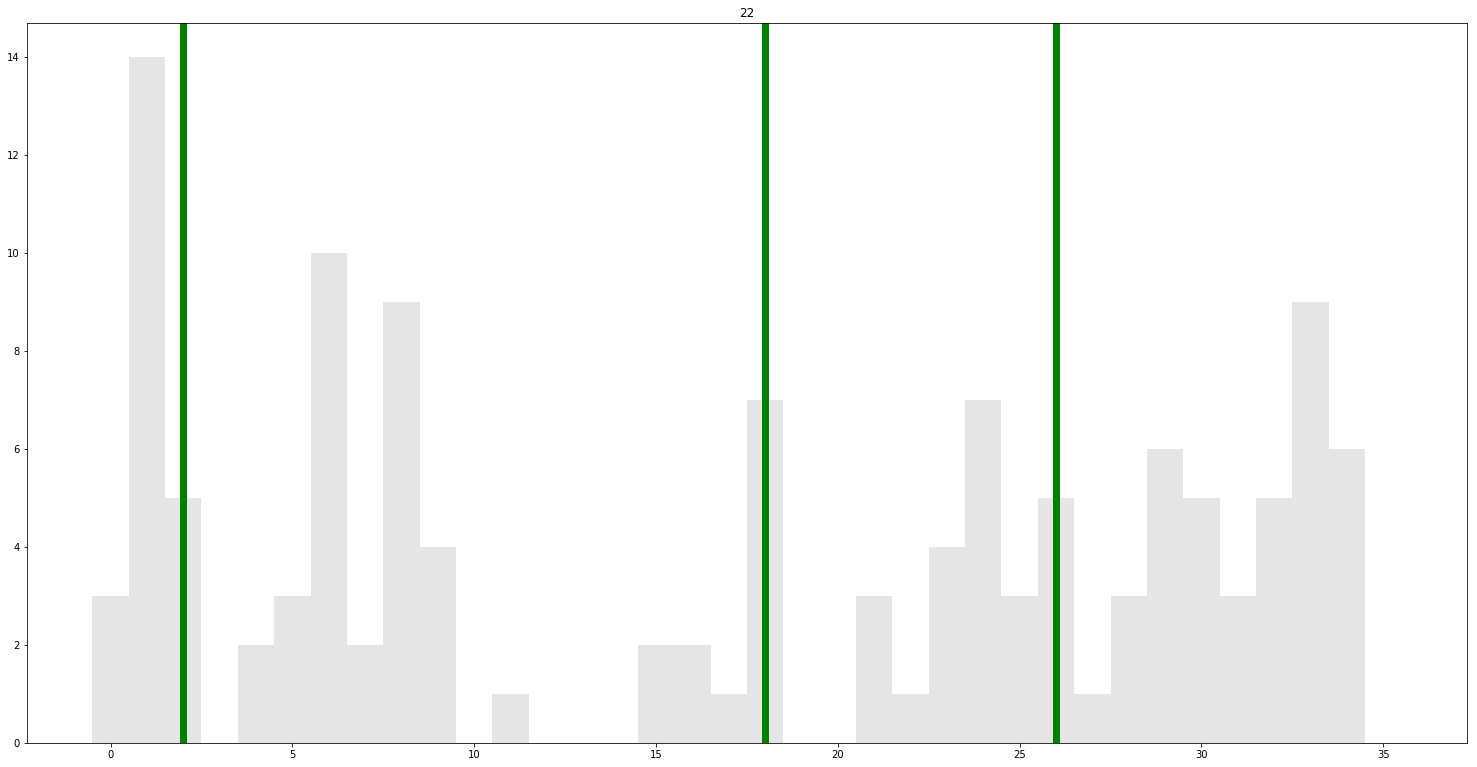

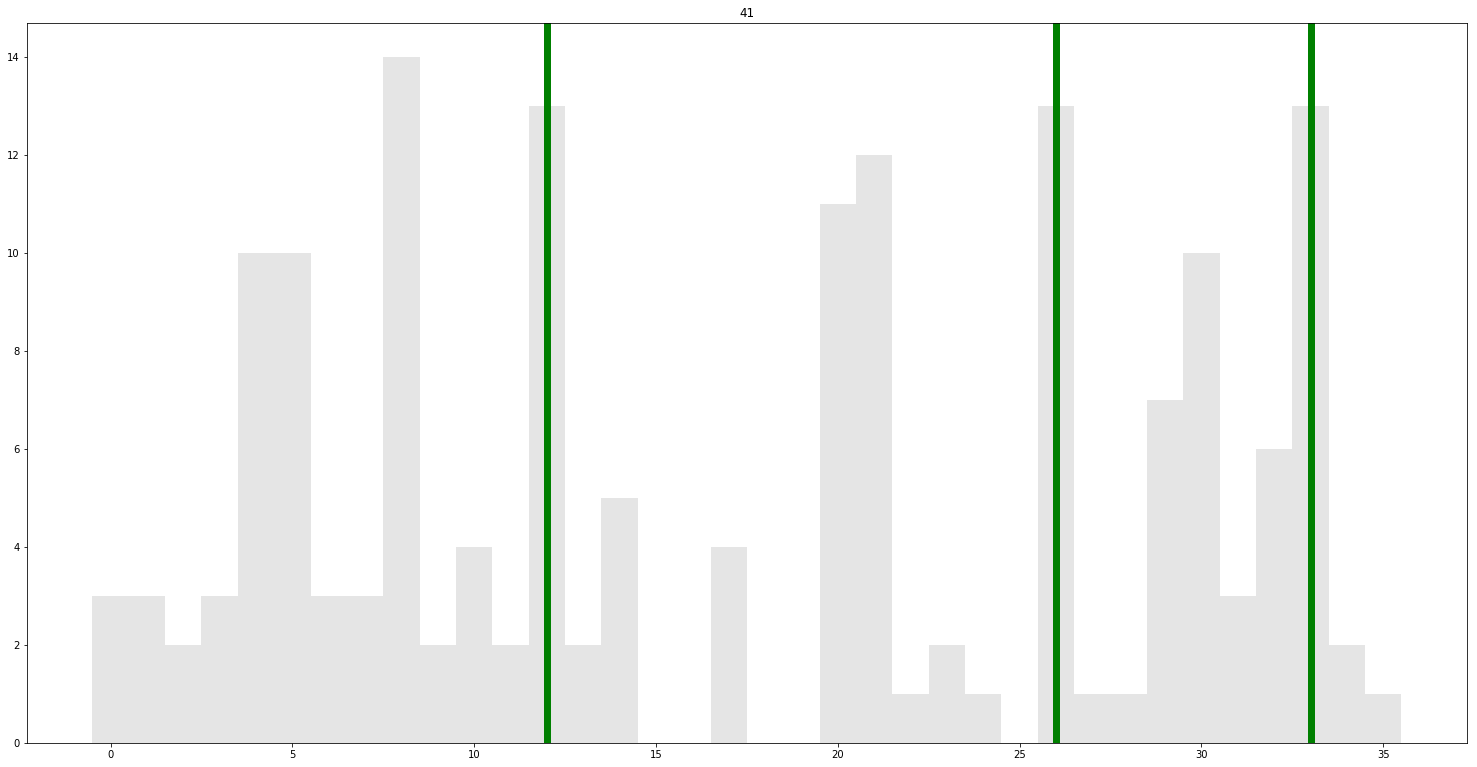

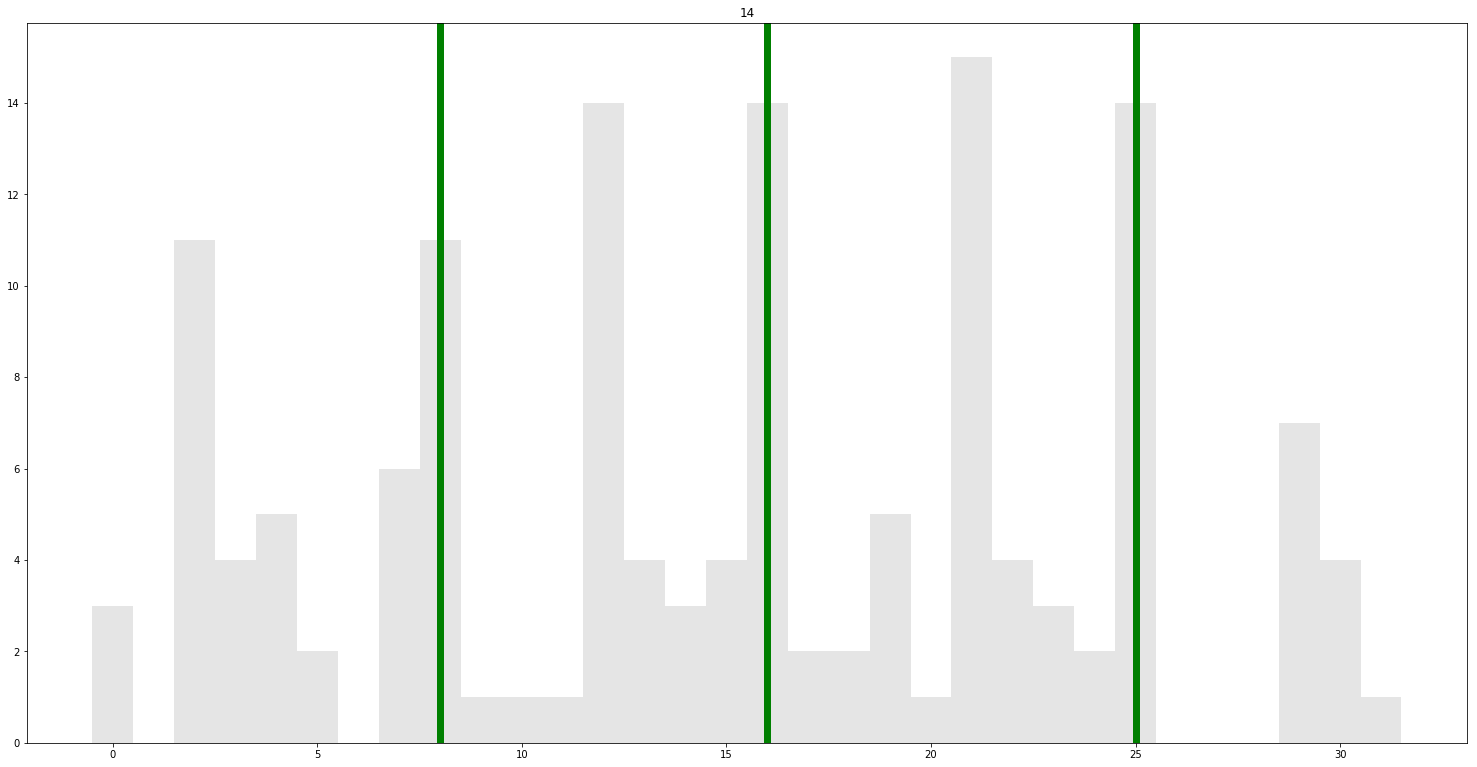

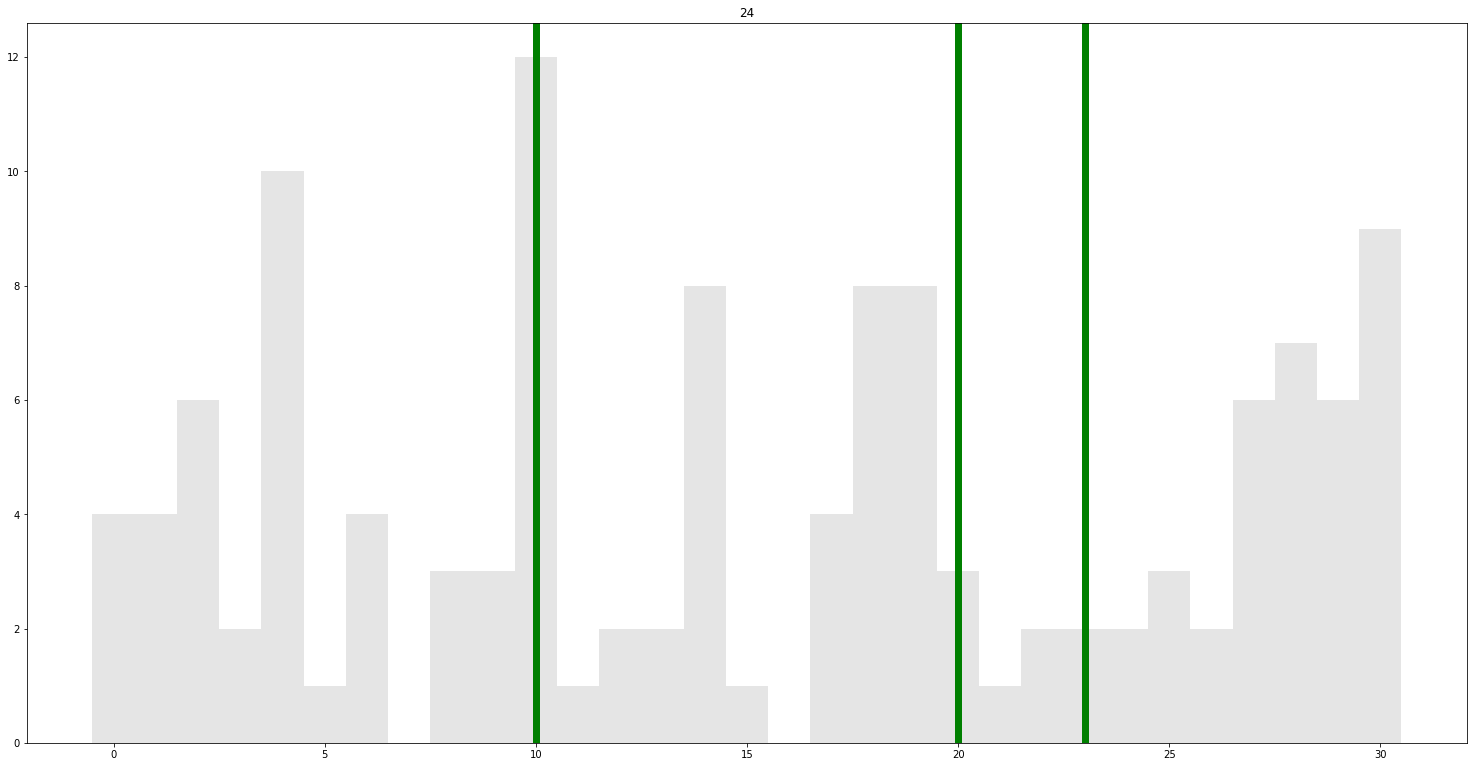

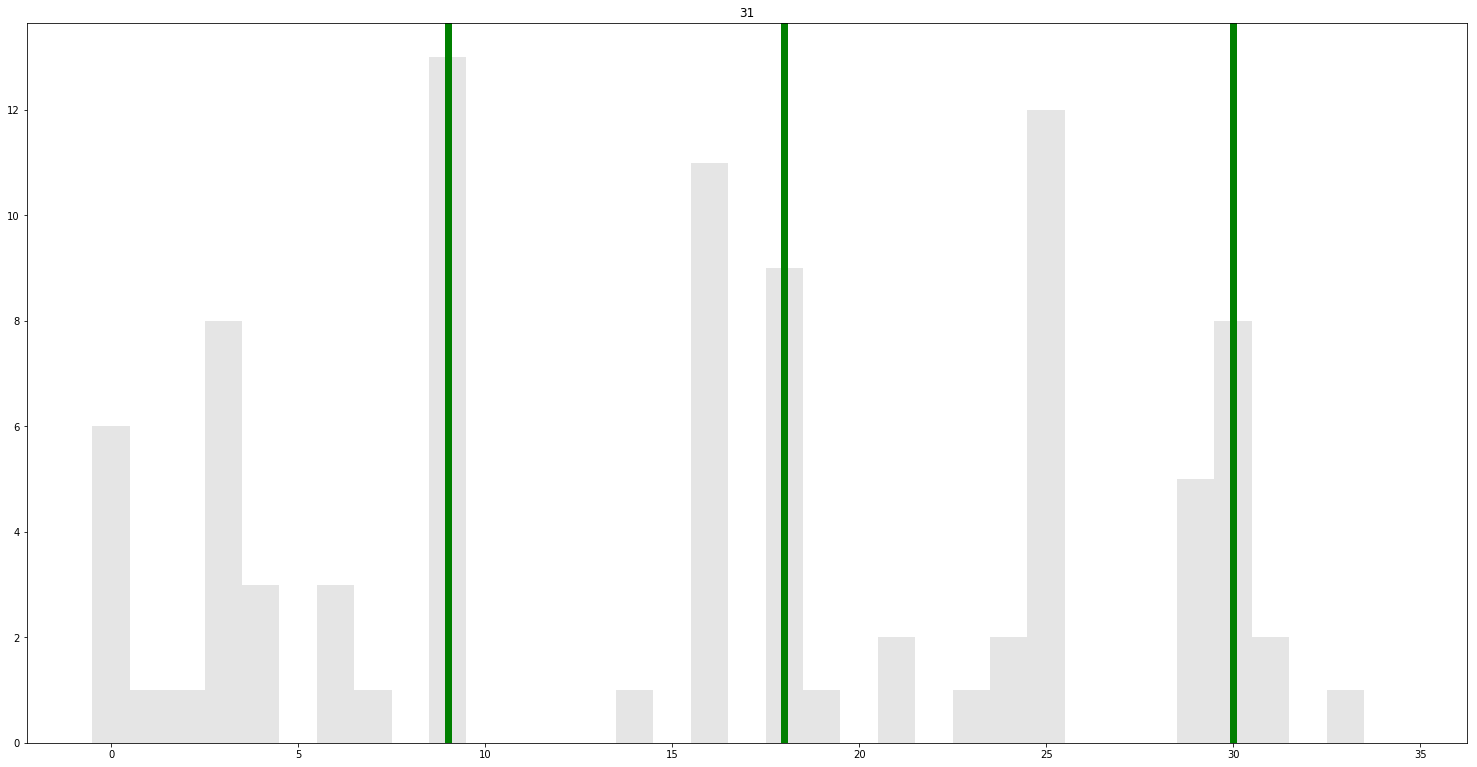

In [16]:
# Instantiating new dict and iterating through all_keys summing along row-wise
sum_keys = {}

for key in all_keys:
    these_keys = all_keys[key]
    sum_keys[key] = np.sum(these_keys, axis = 1)

# Plot each sum_keys array with loc boundaries
for key in sum_keys:
    X = np.arange(len(sum_keys[key]))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X, sum_keys[key], color = 'k', width = 1, alpha=0.1)
    ax.set_title(key)
    # Plotting the social boundaries
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = 'g', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = 'g', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = 'g', linewidth=7.0)

## C. Compare aggregated keypresses to both location and social boundaries

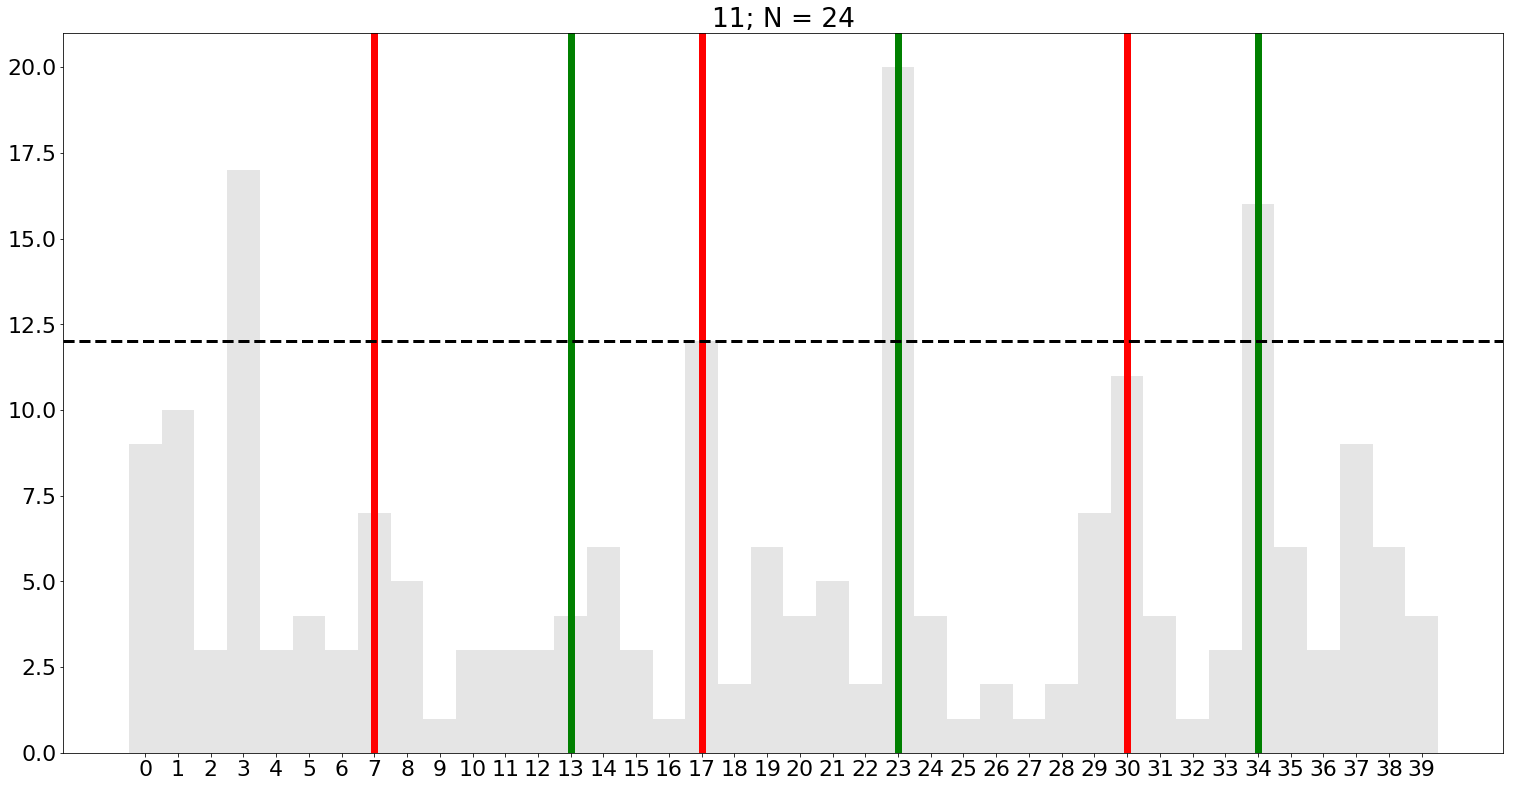

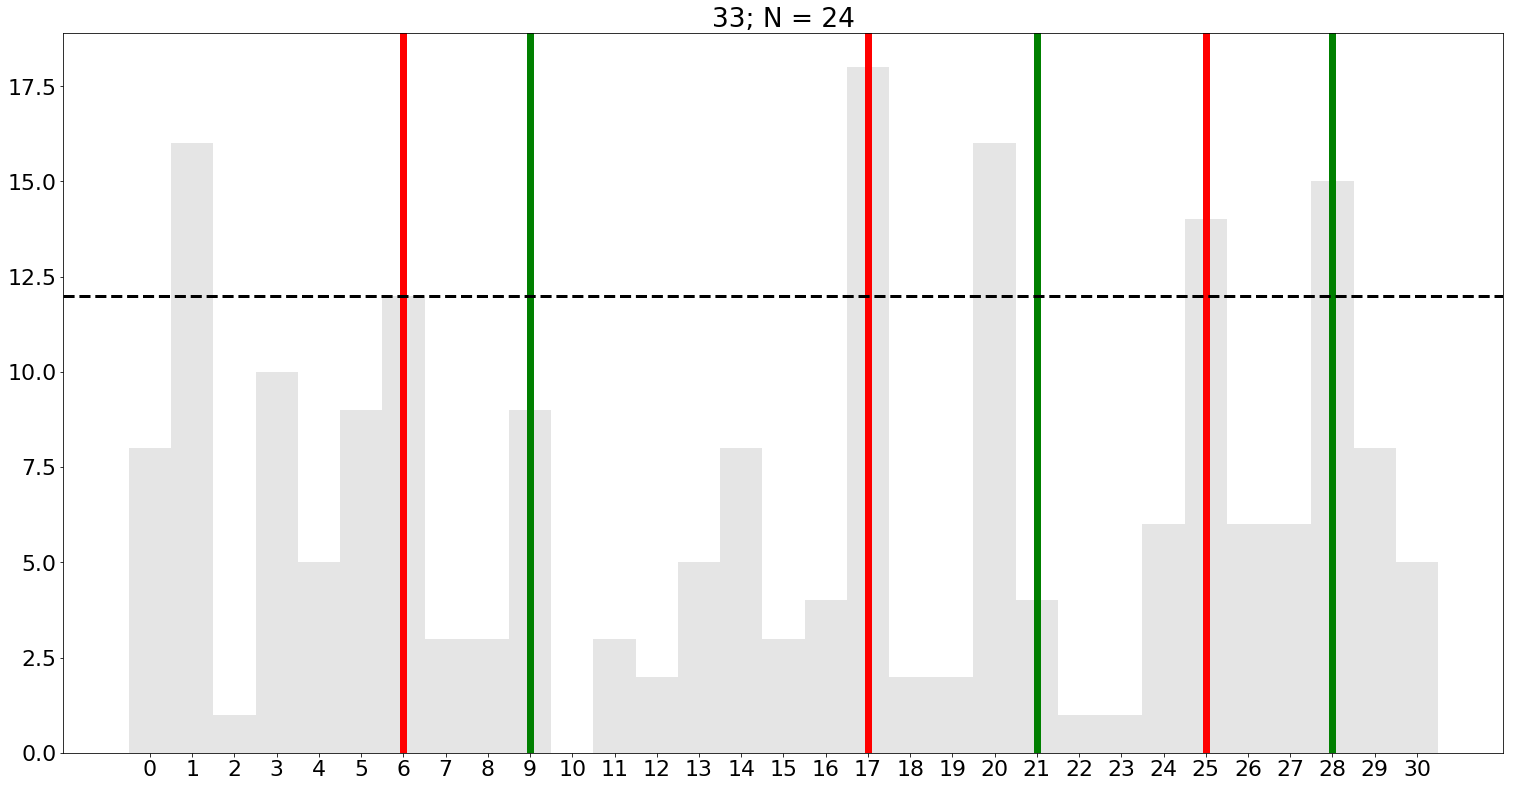

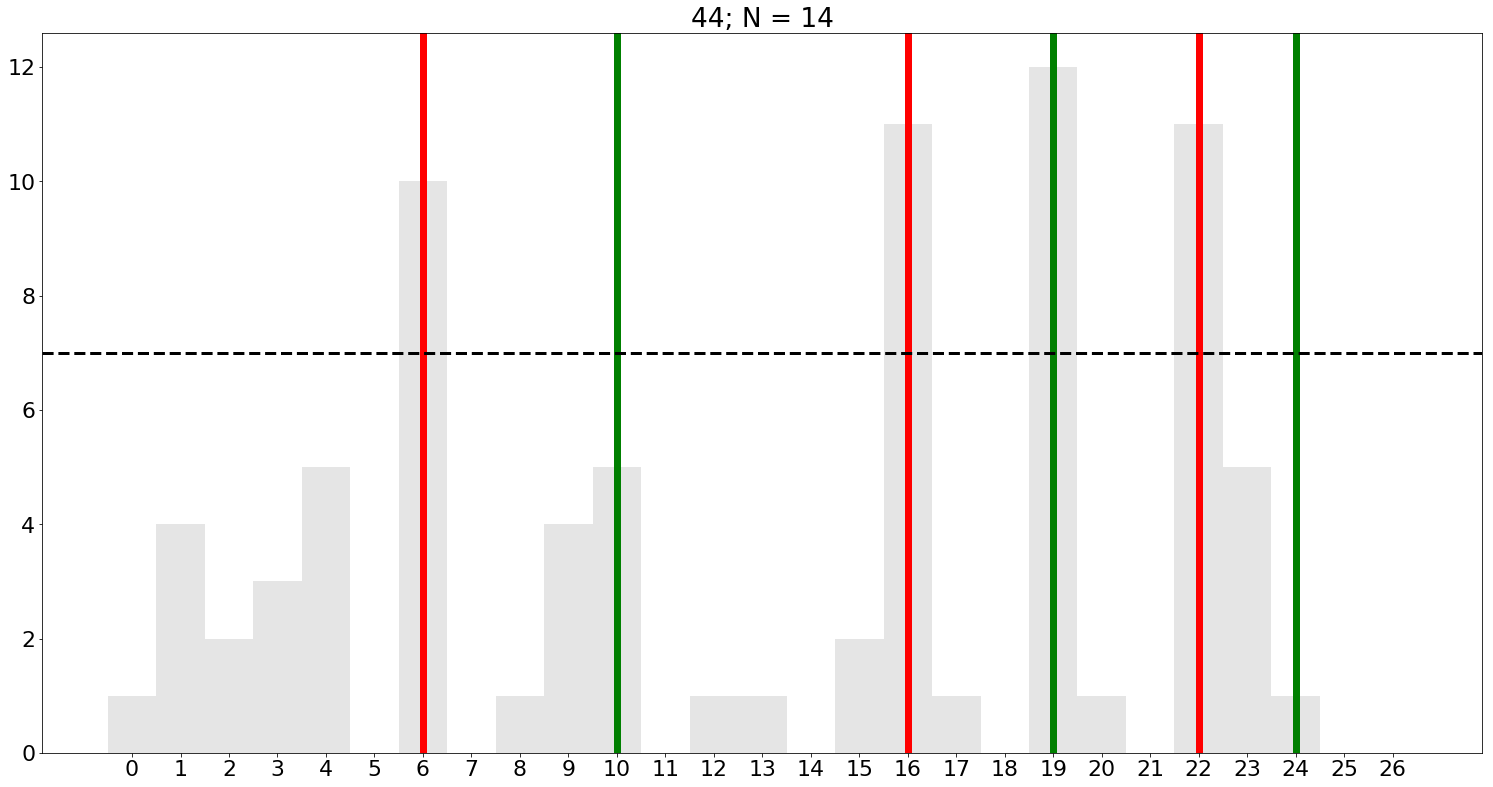

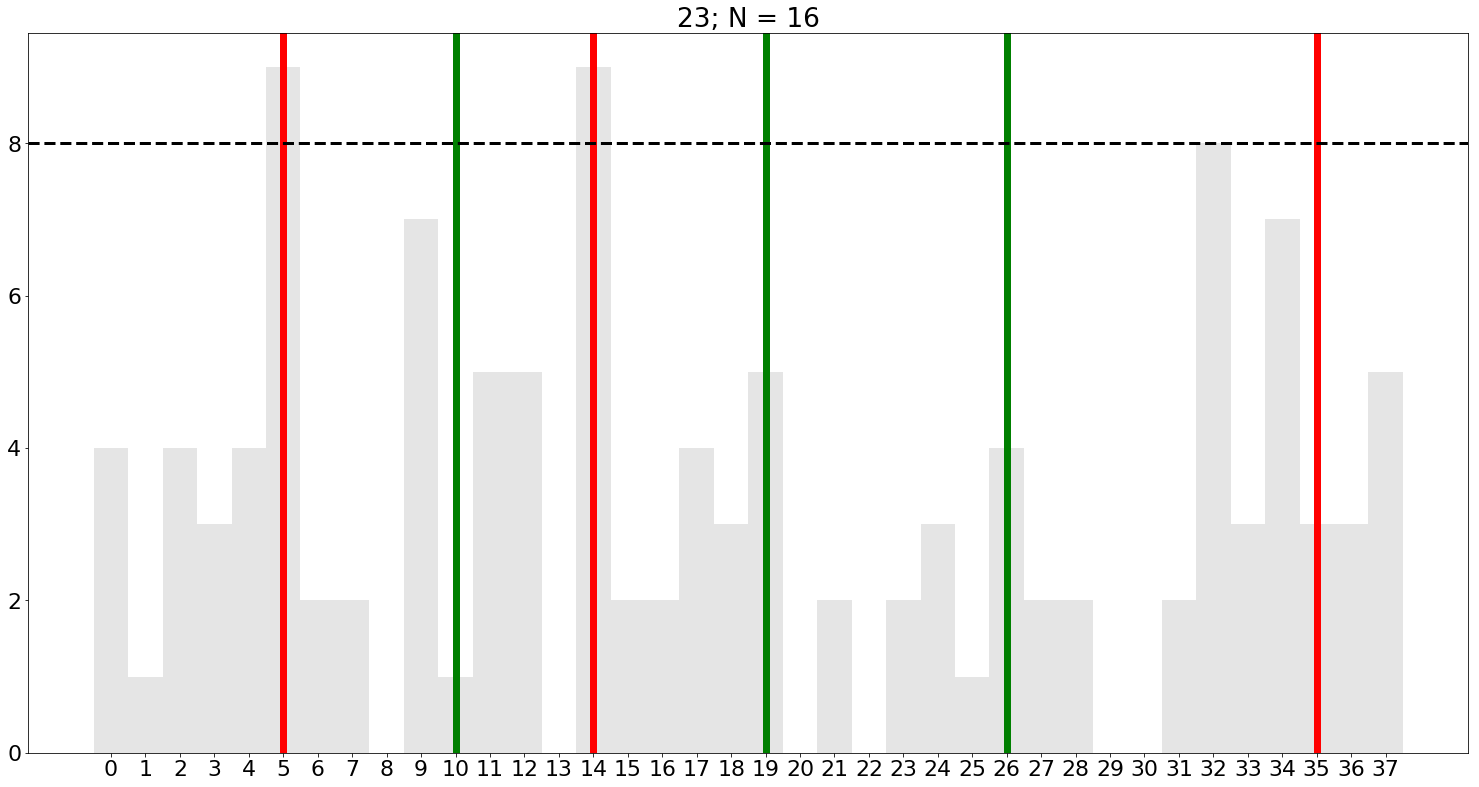

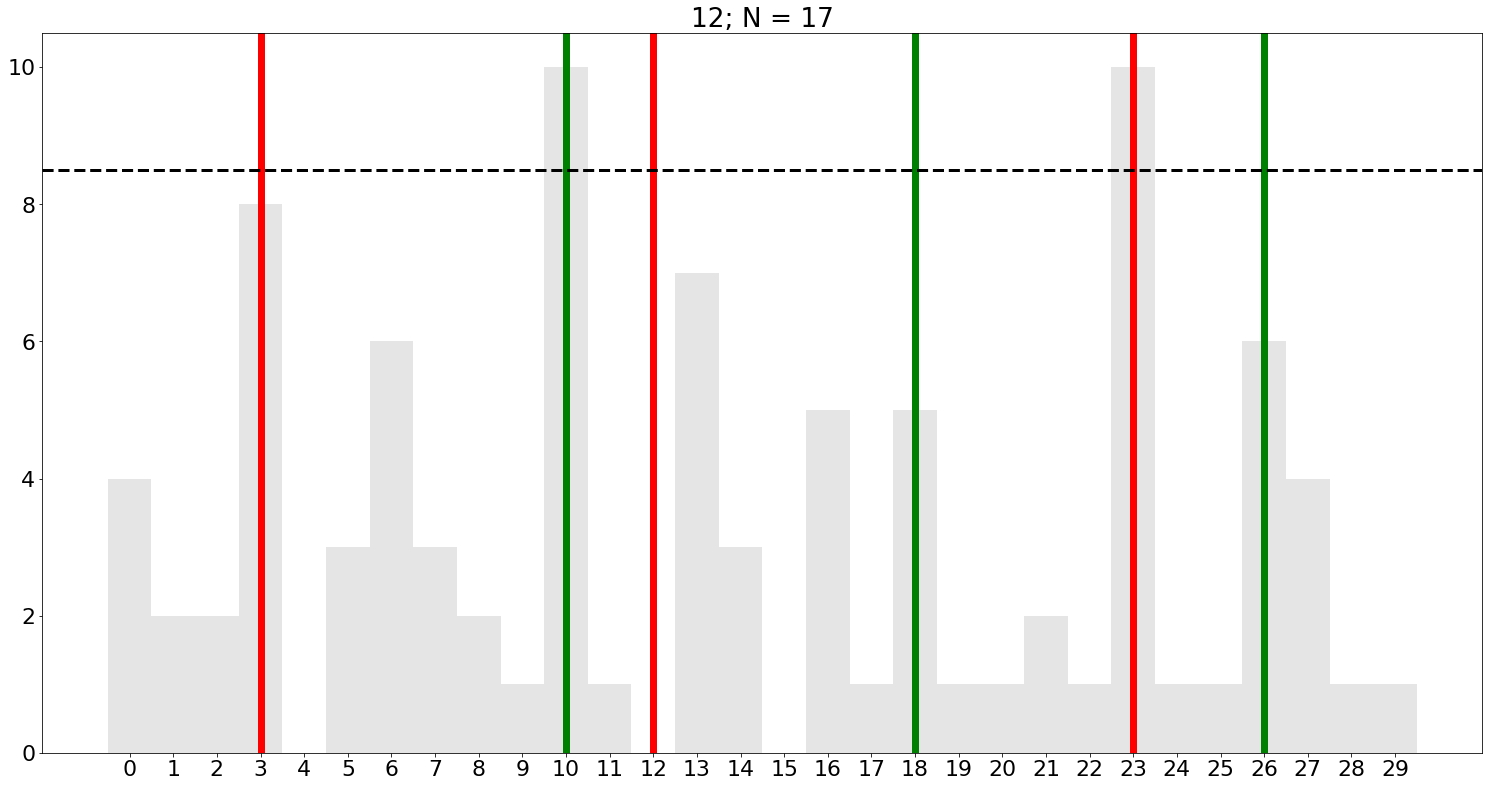

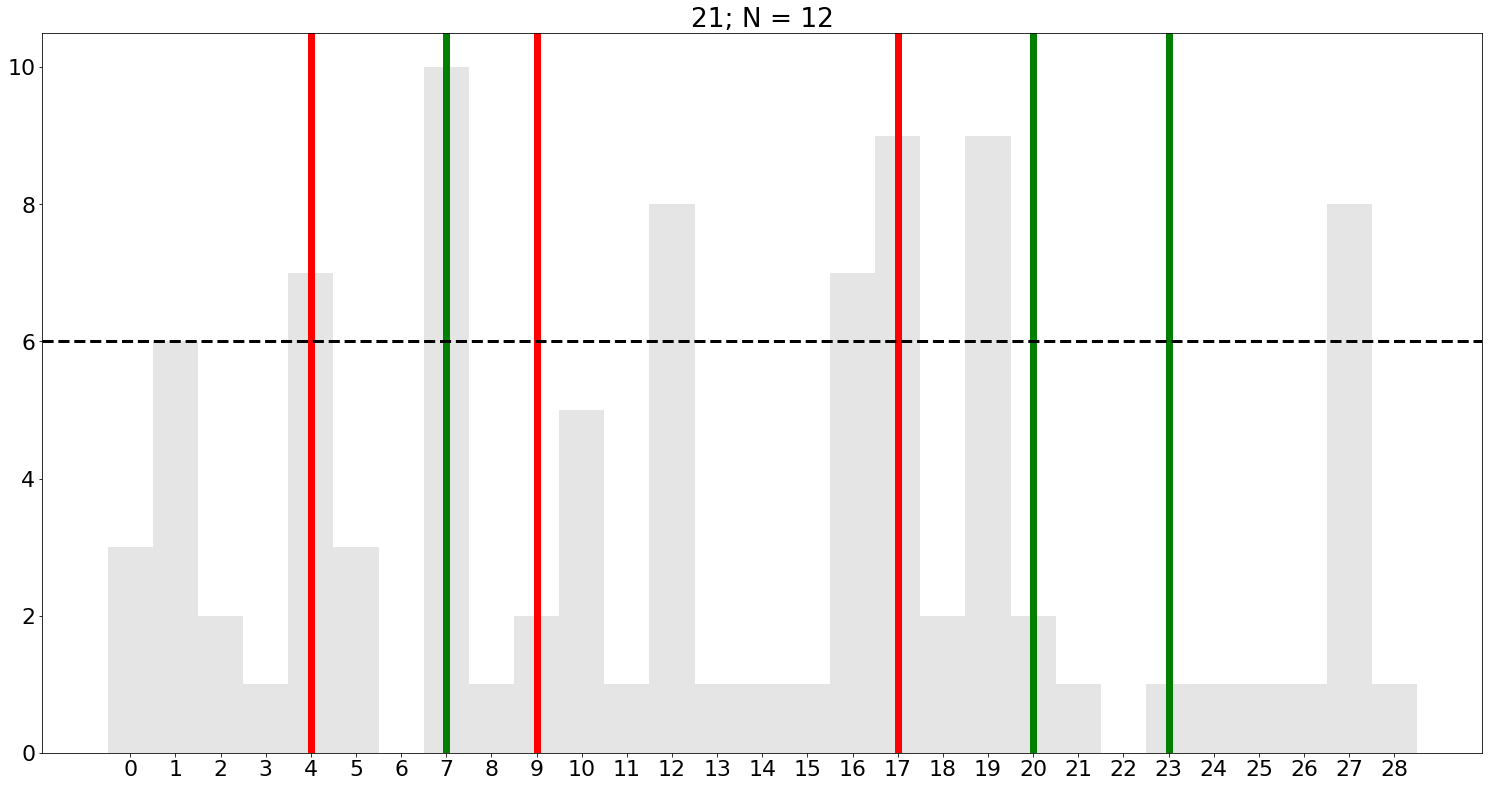

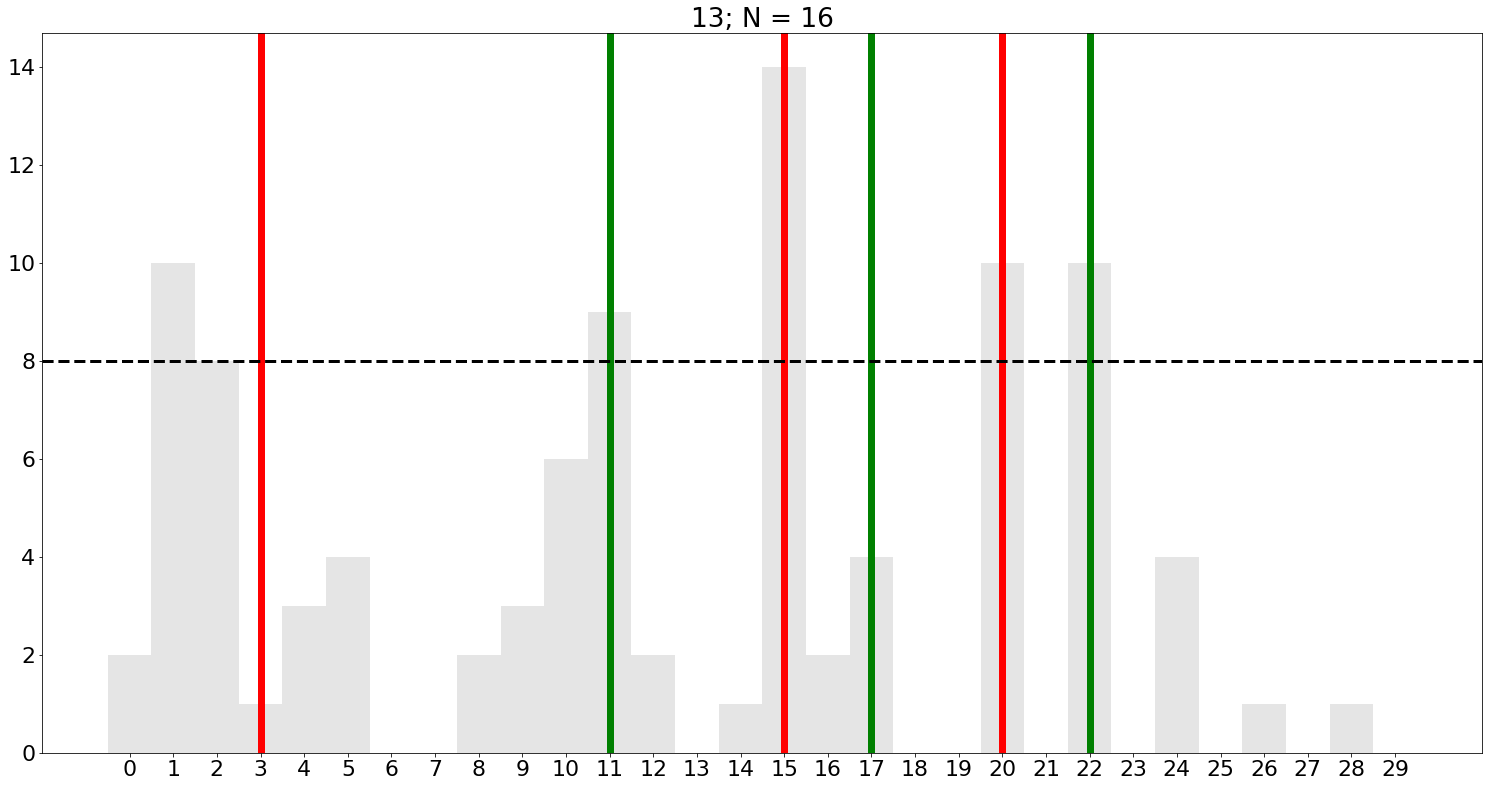

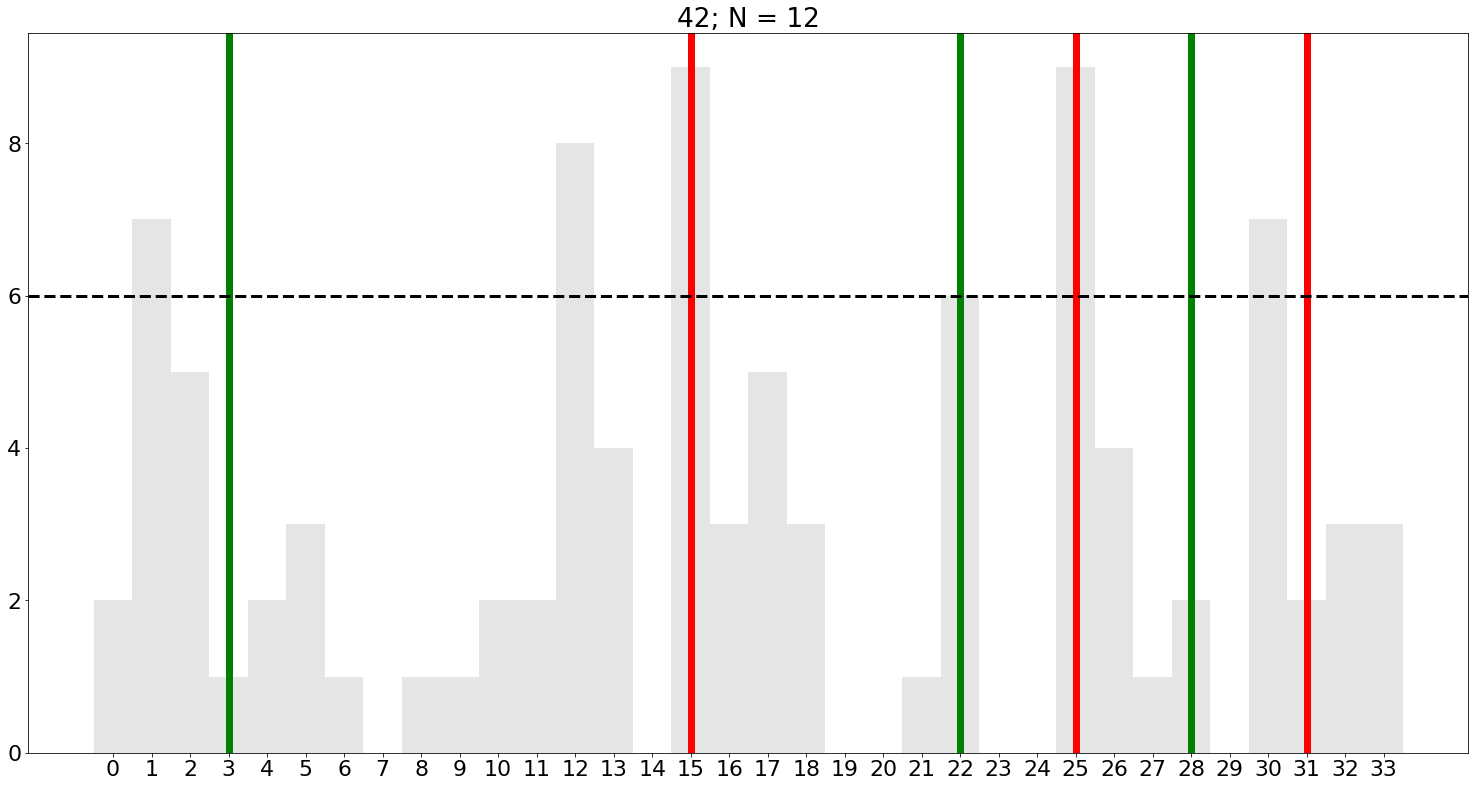

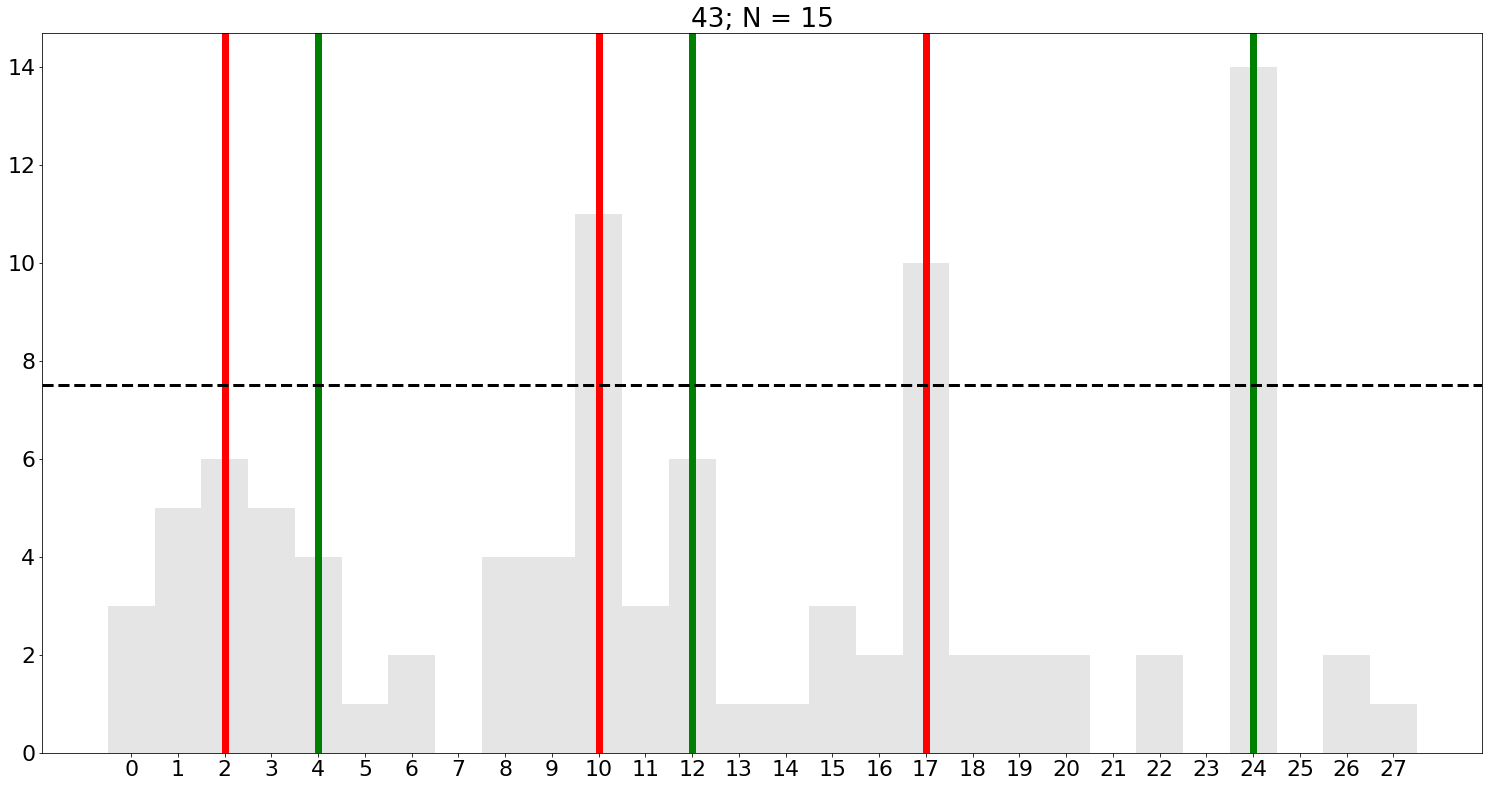

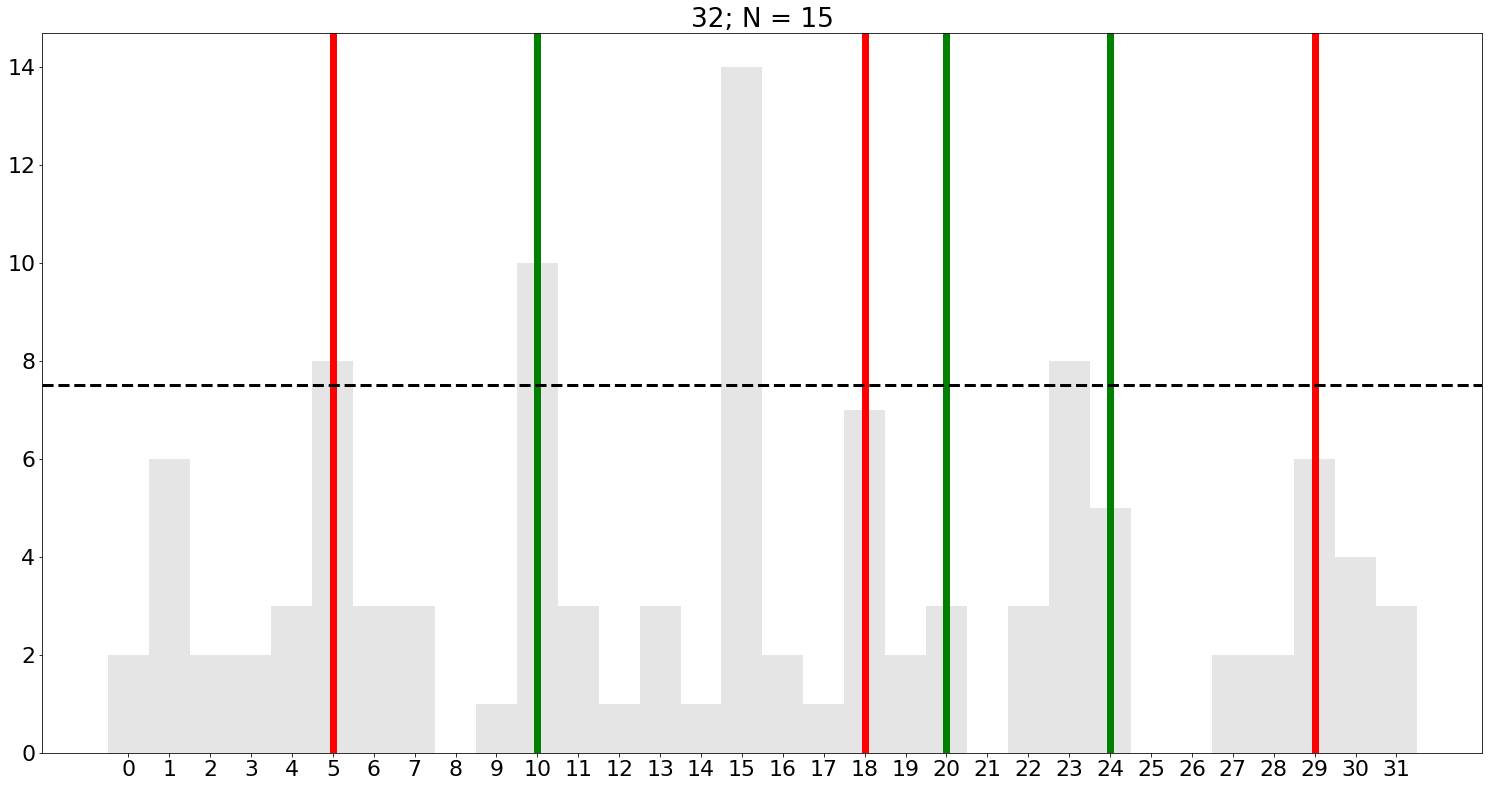

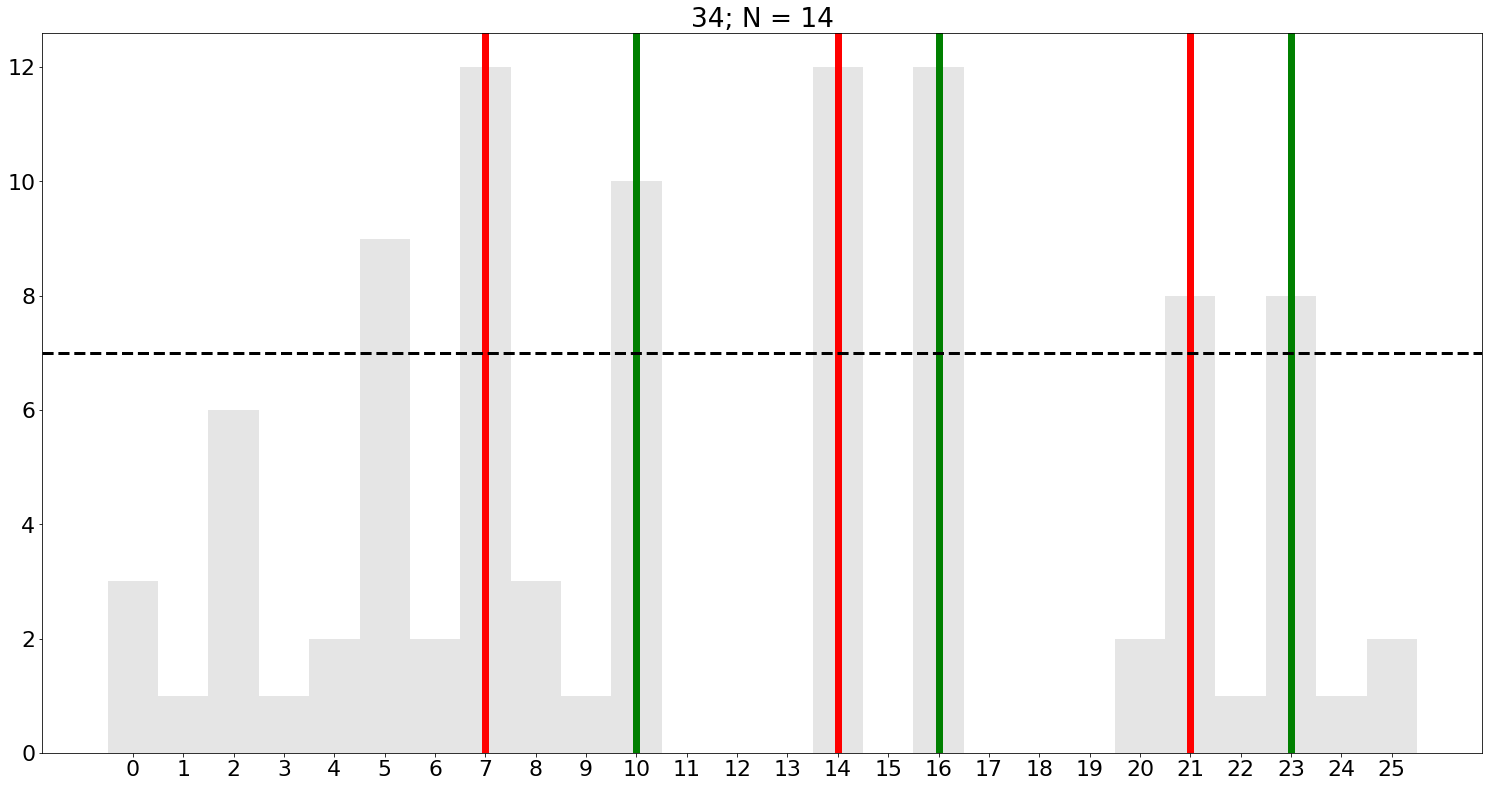

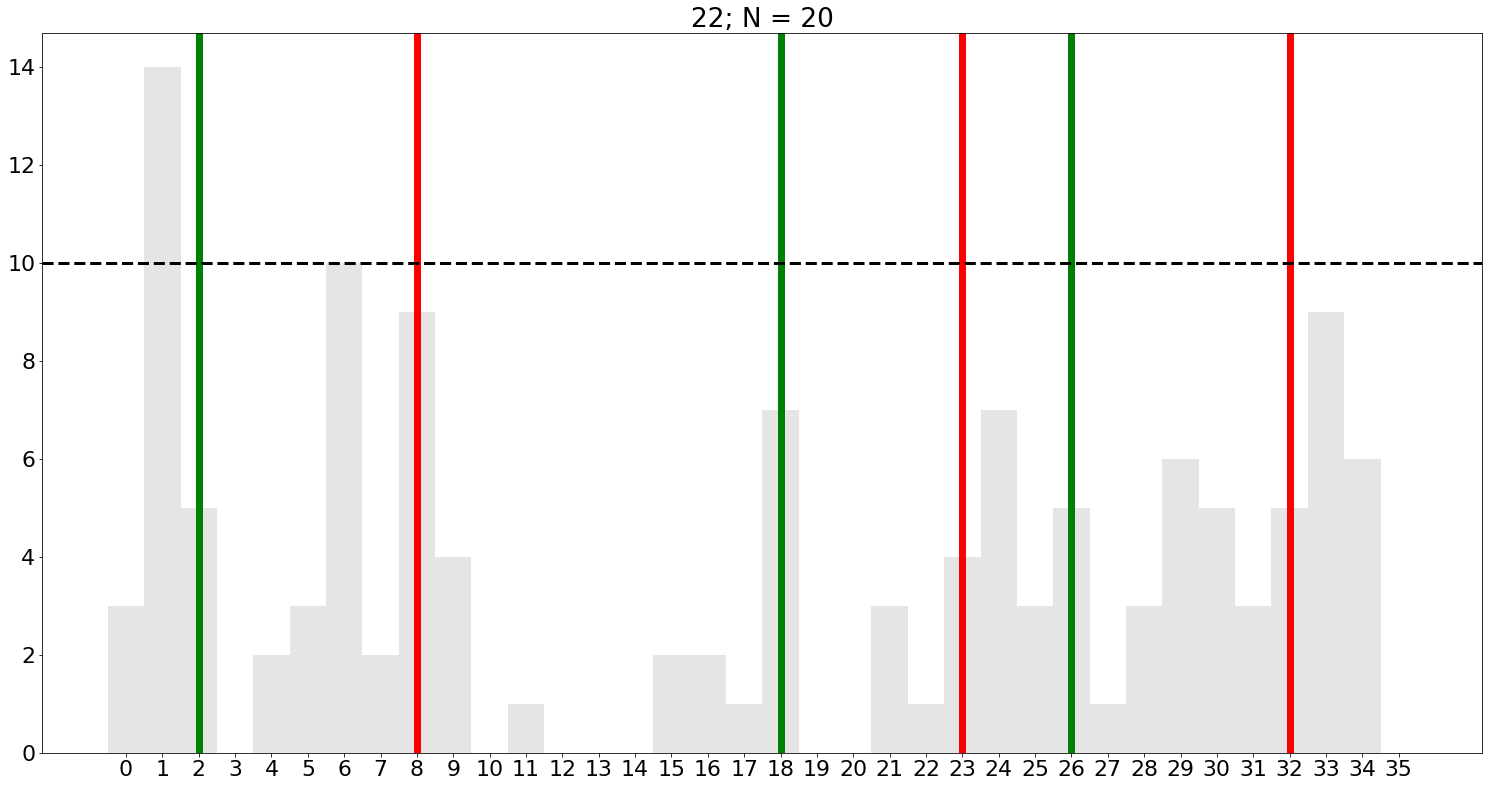

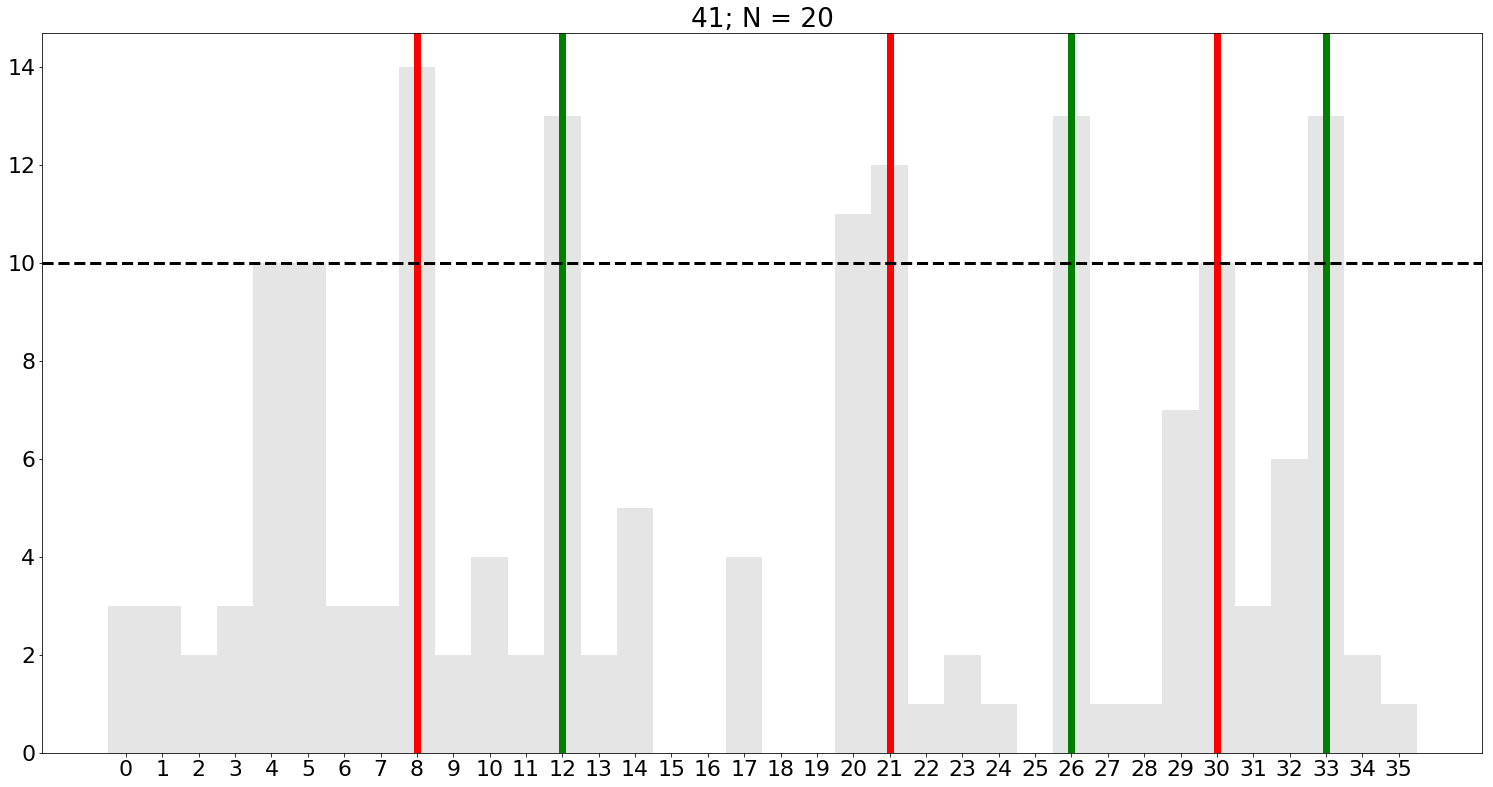

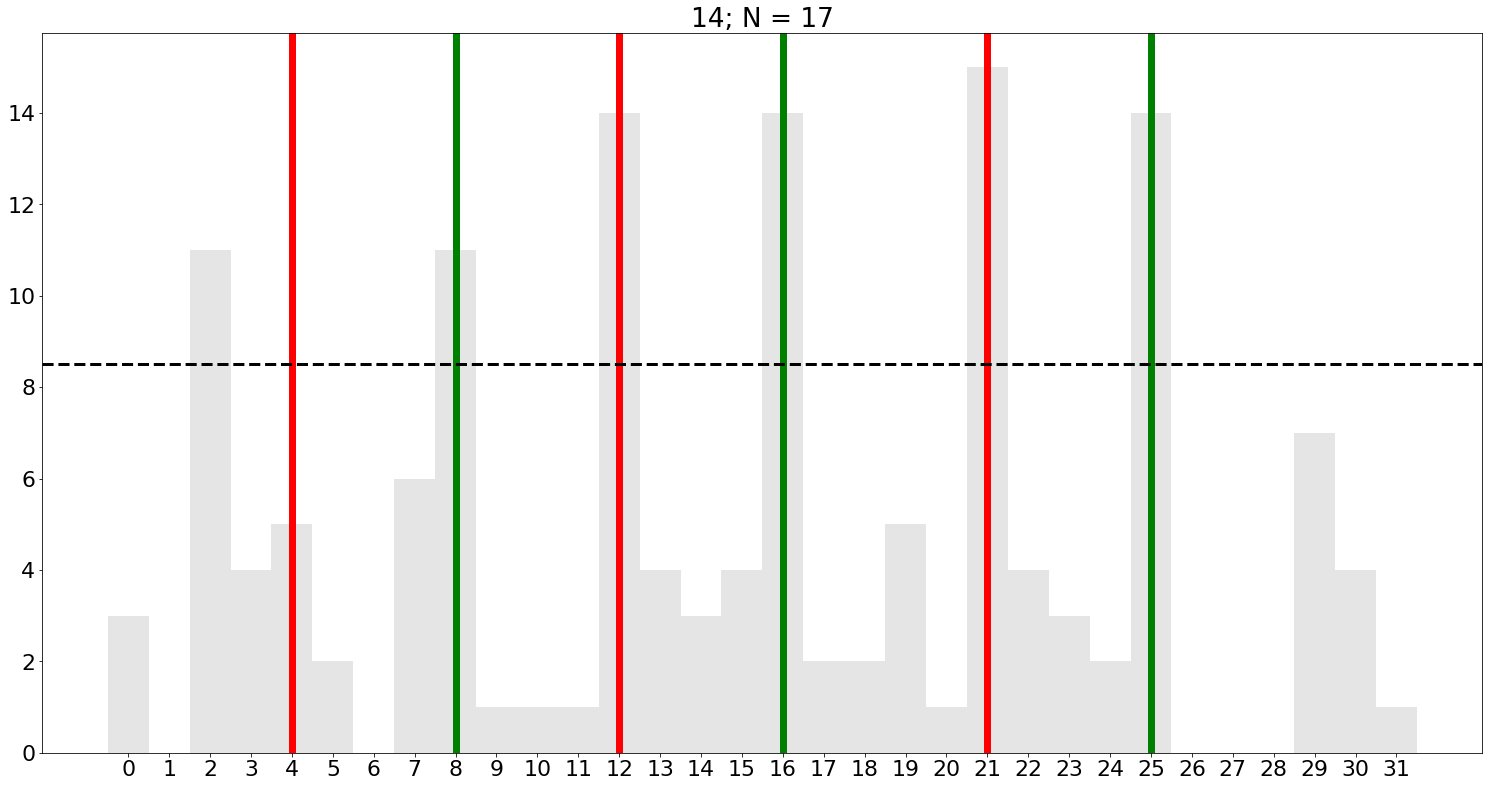

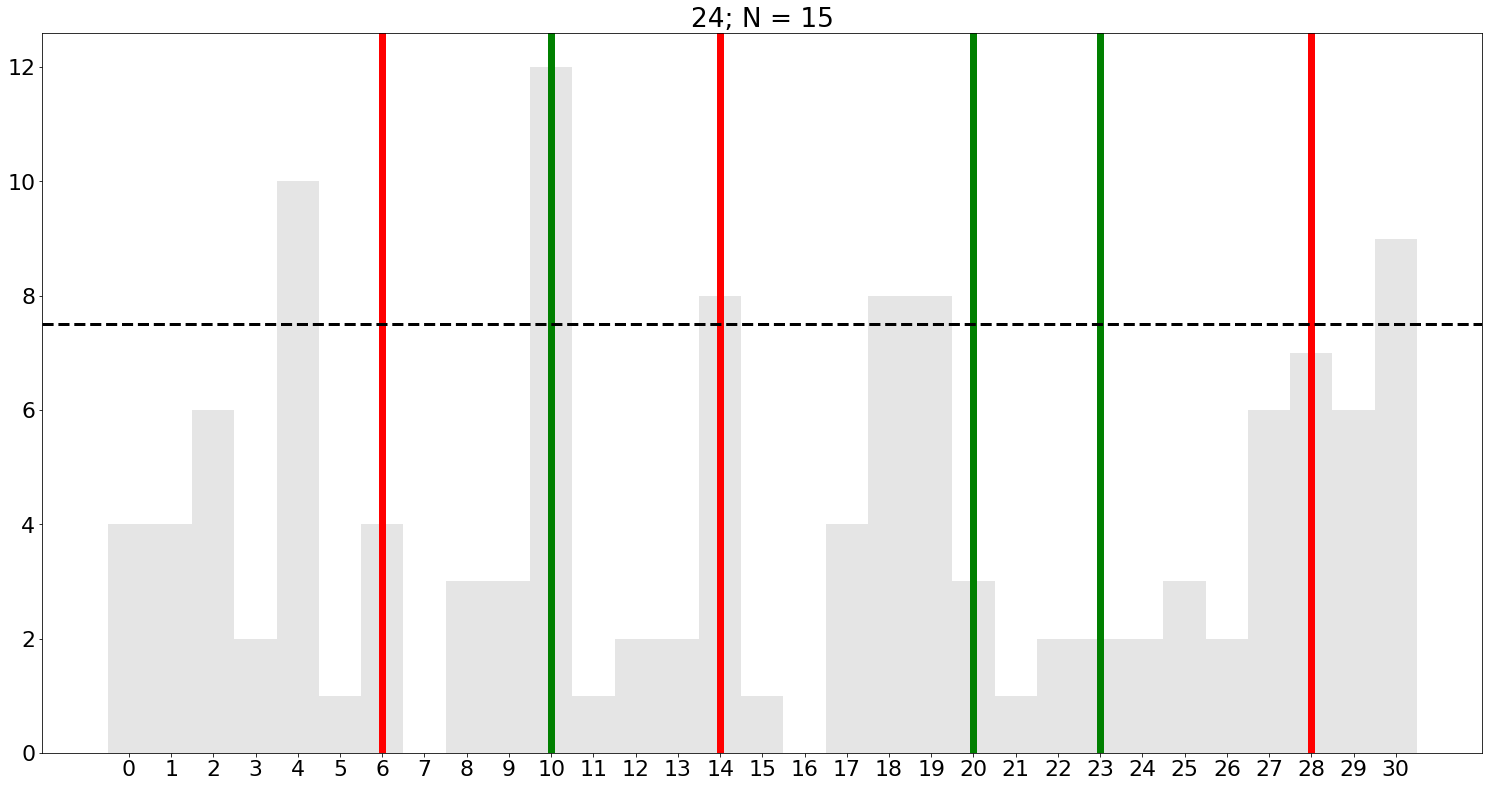

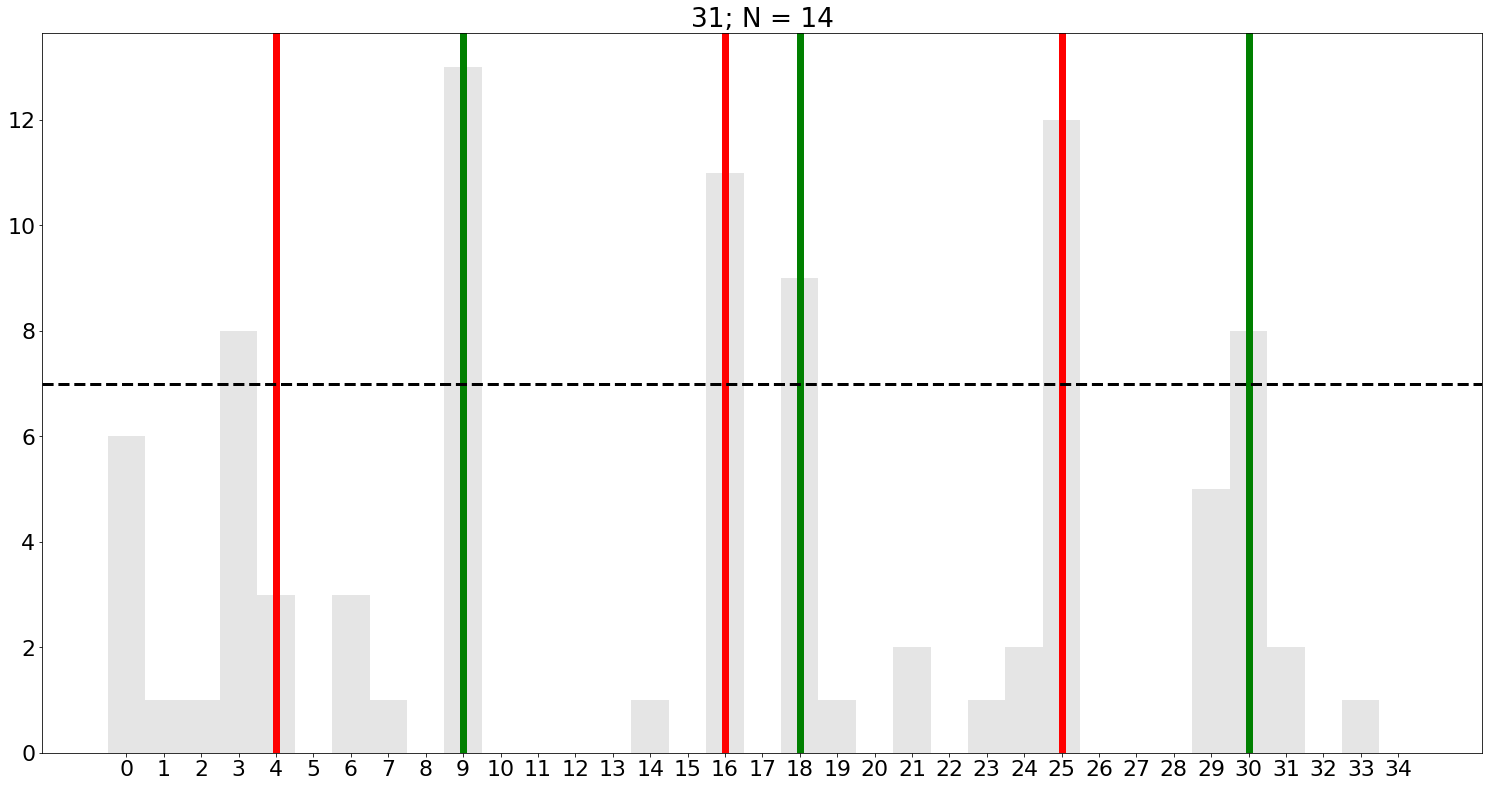

In [19]:
# Instantiating new dict and iterating through all_keys summing along row-wise
sum_keys = {}

for key in all_keys:
    these_keys = all_keys[key]
    sum_keys[key] = np.sum(these_keys, axis = 1)
    
plt.rcParams.update({'font.size': 22})

# Plot each sum_keys array with loc boundaries
for key in sum_keys:
    X = np.arange(len(sum_keys[key]))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X, sum_keys[key], color = 'k', width = 1, alpha=0.1)
    ax.set_title(str(key) + '; N = ' +  str(sums[key][0]))
    # Plotting the social boundaries
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = 'g', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = 'g', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = 'g', linewidth=7.0)
    # Plotting the location boundaries
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = 'r', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = 'r', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = 'r', linewidth=7.0)
    # Horizontal line
    plt.axhline(sums[key][0]/2, color = 'k',  ls='--', linewidth=3.0)
    # Tick Marks
    plt.xticks(np.arange(len(sum_keys[key])))

# IV. Aggregating keypresses across different priming groups
## A. Plotting 3 priming types for each story

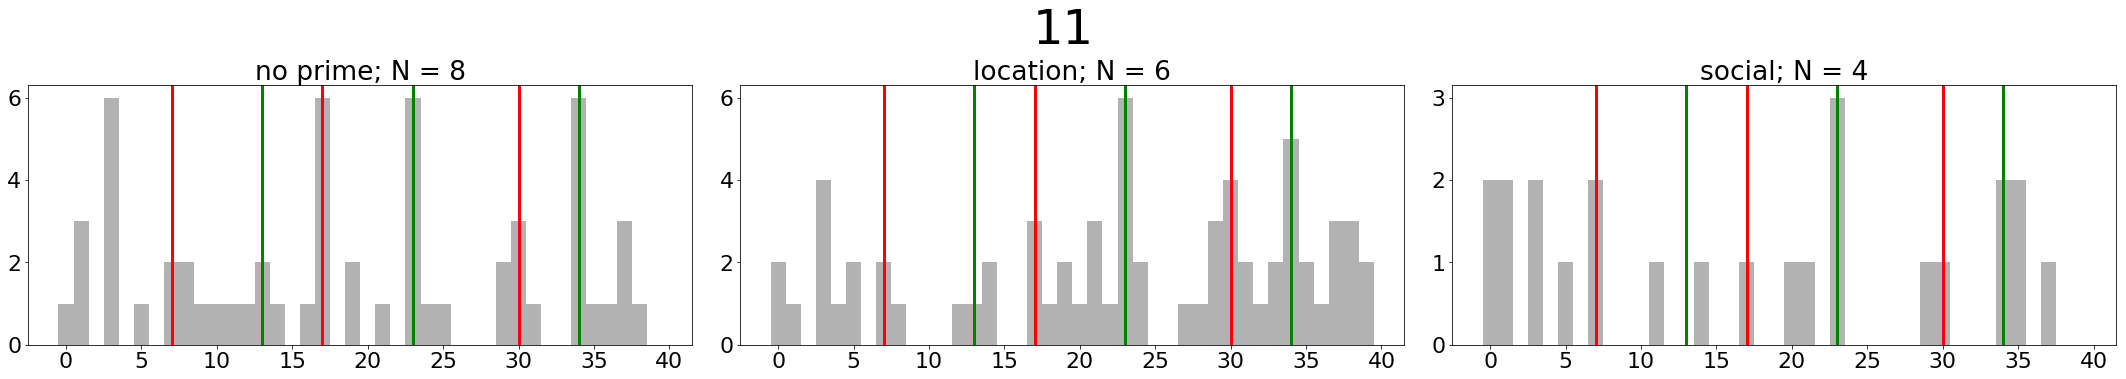

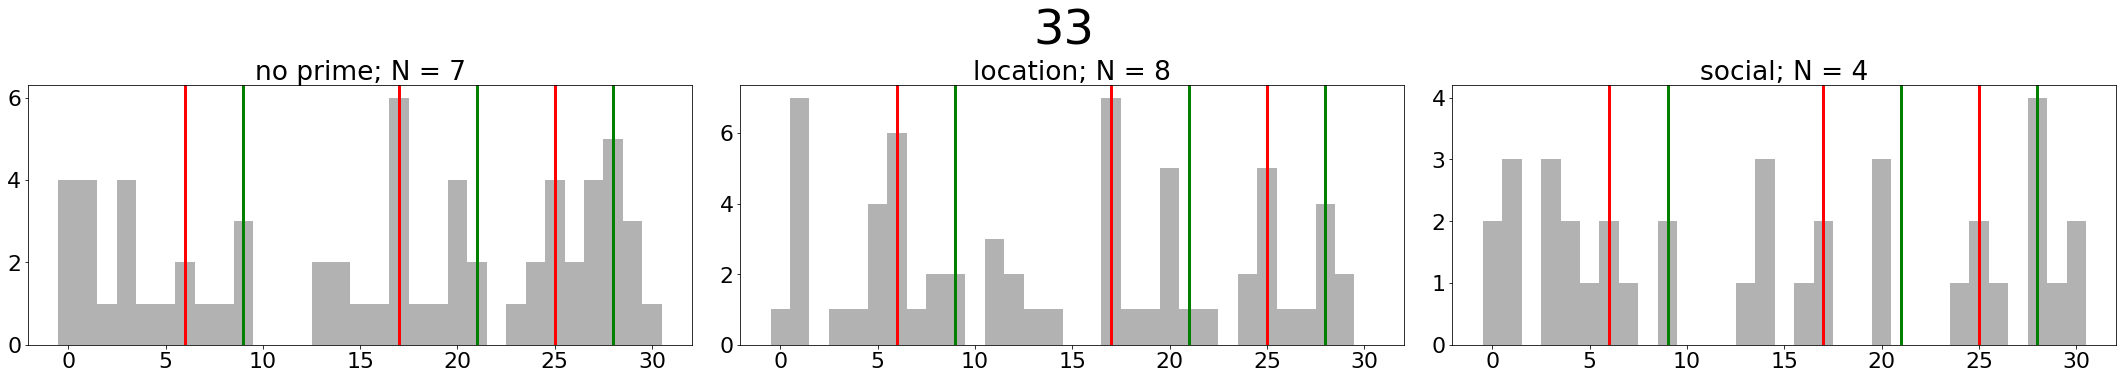

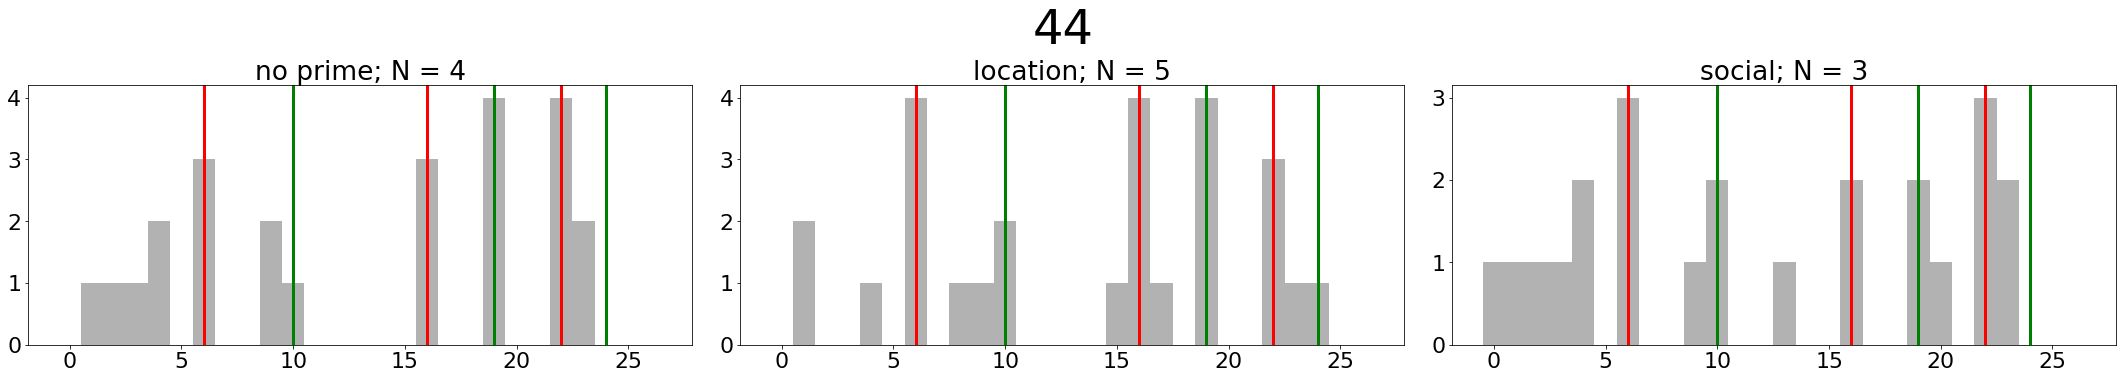

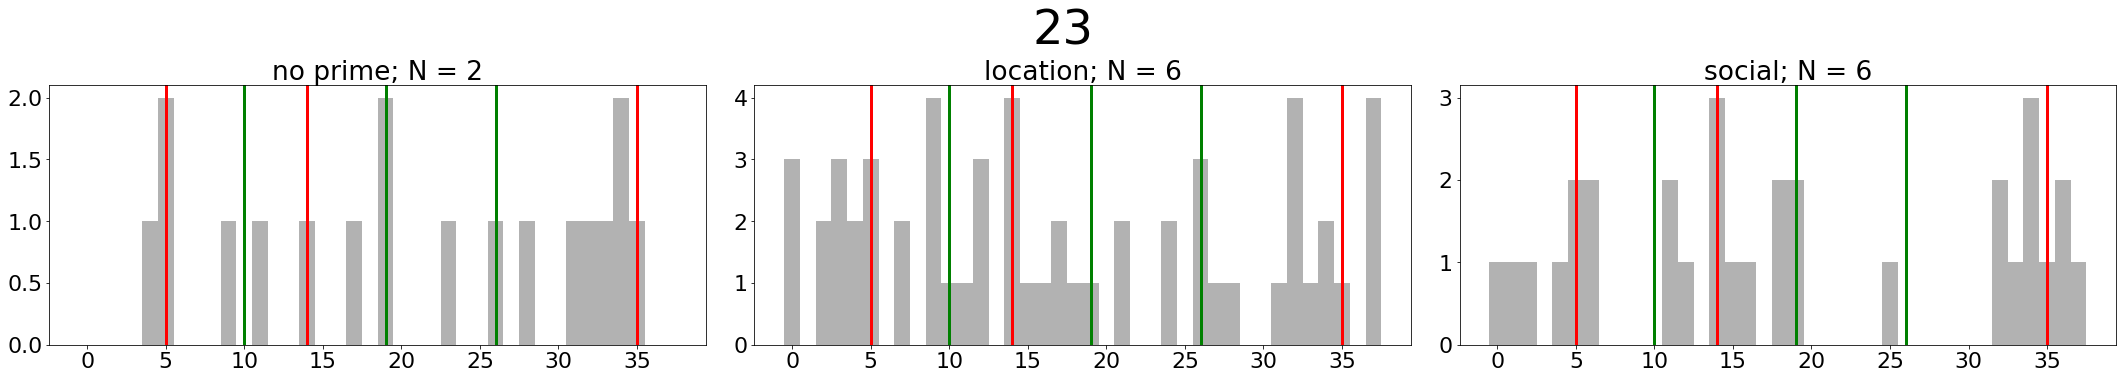

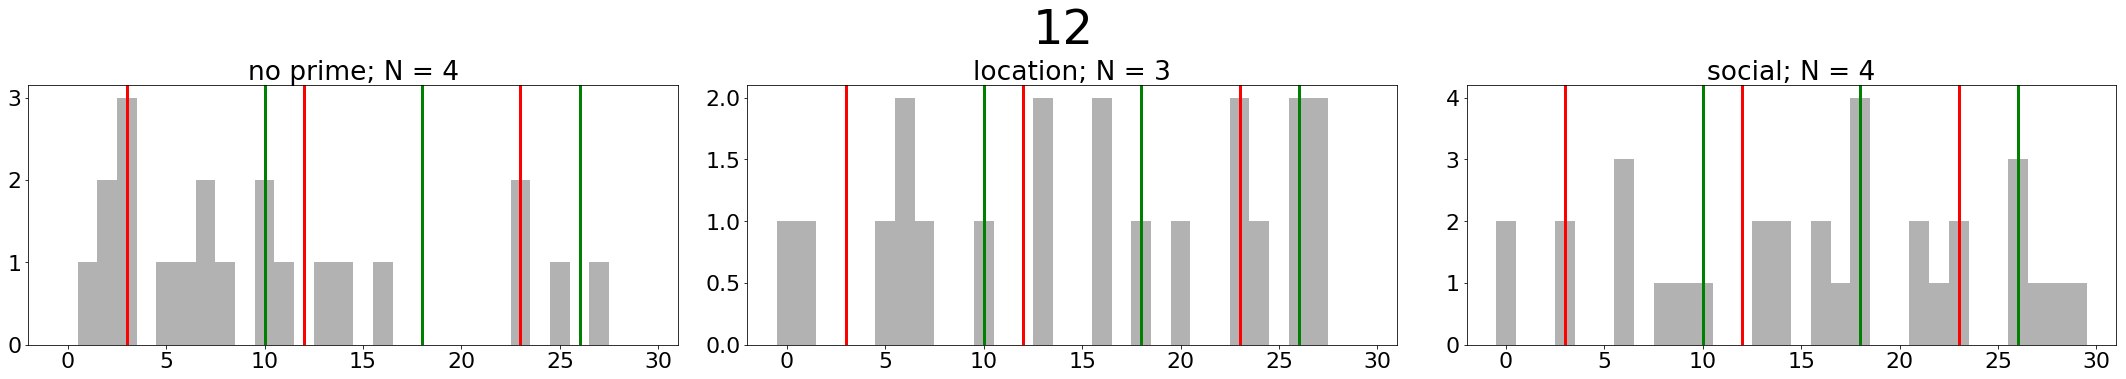

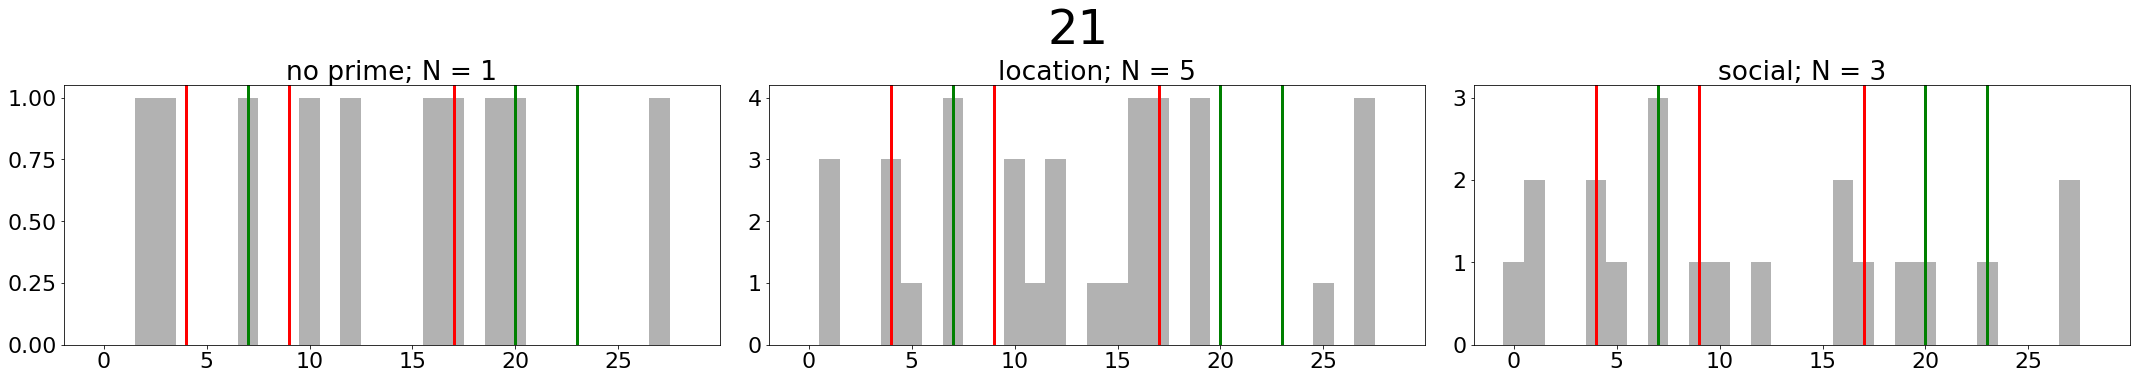

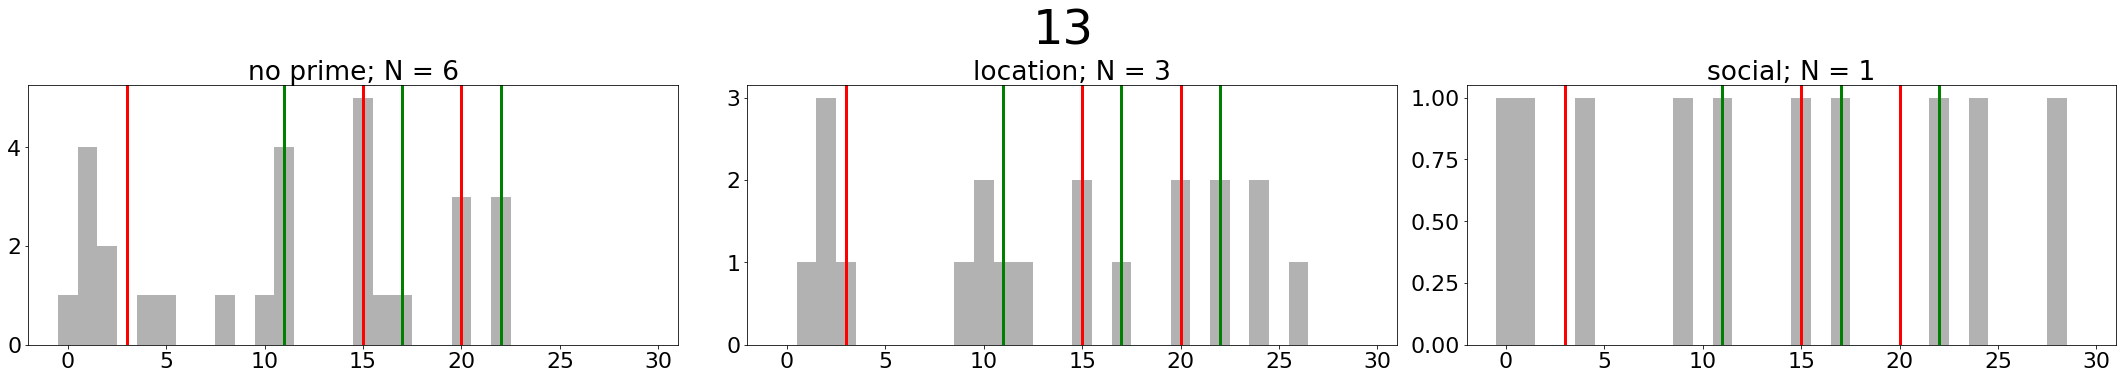

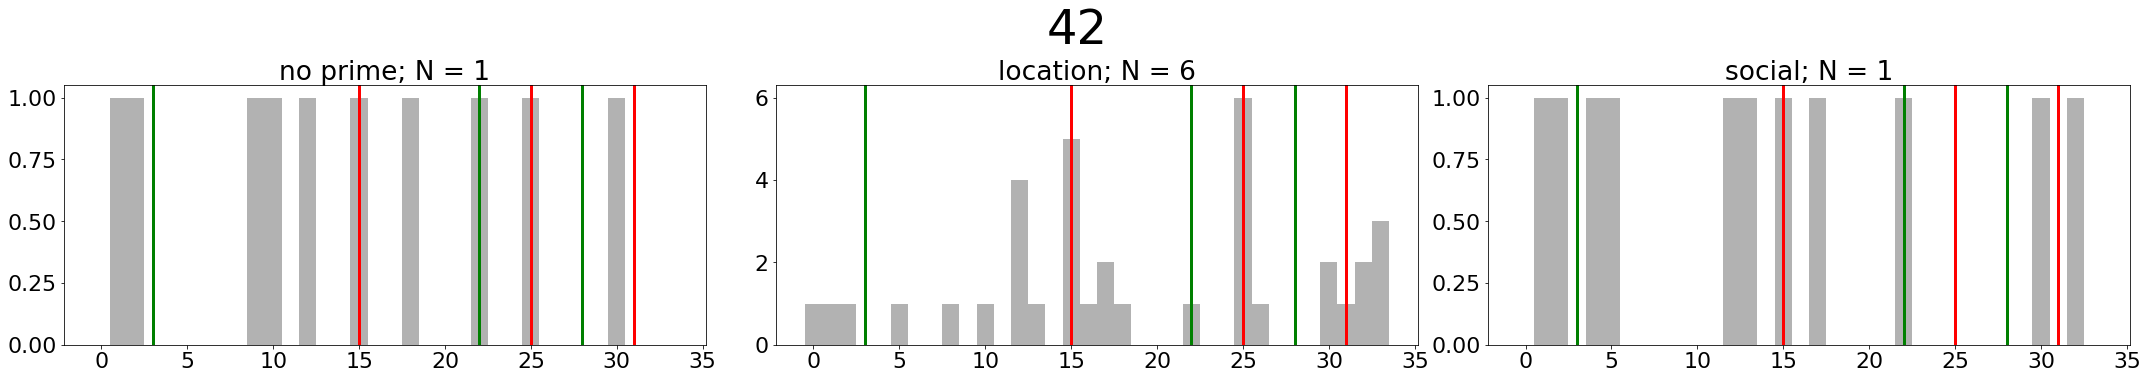

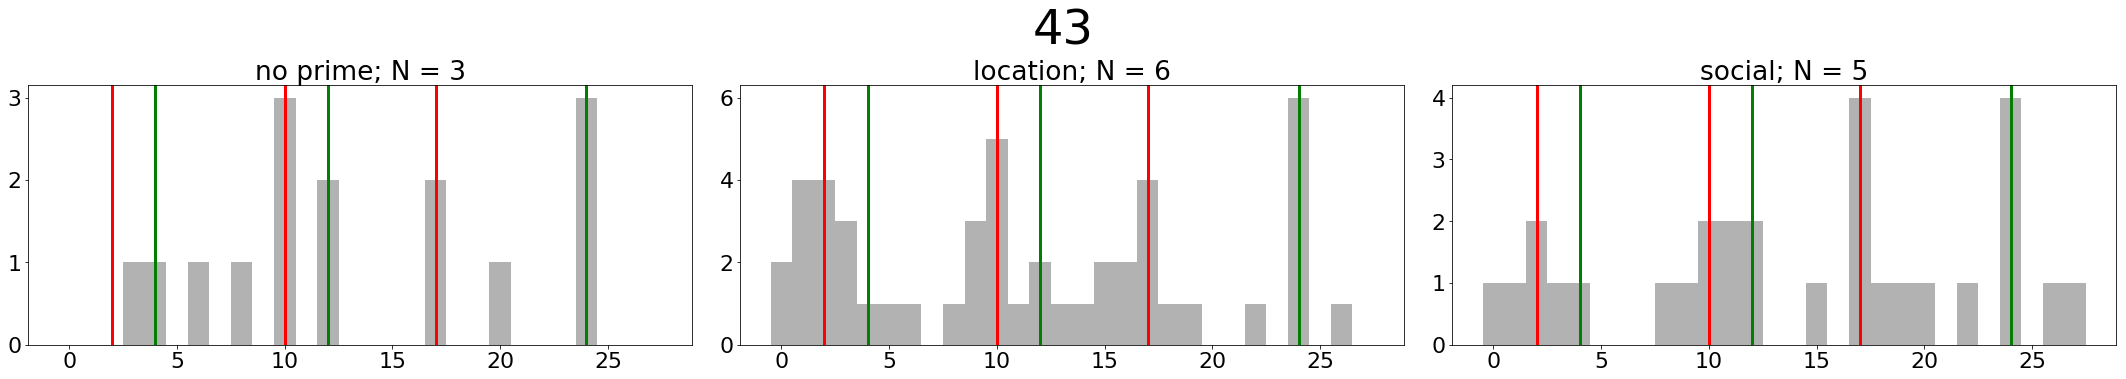

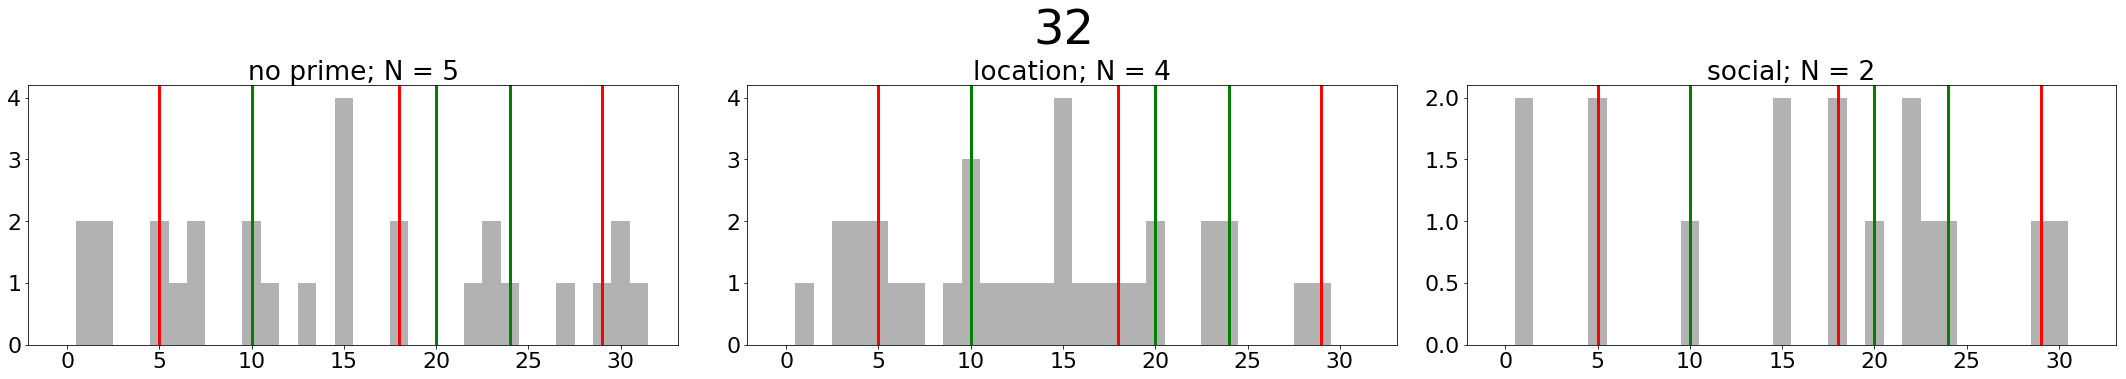

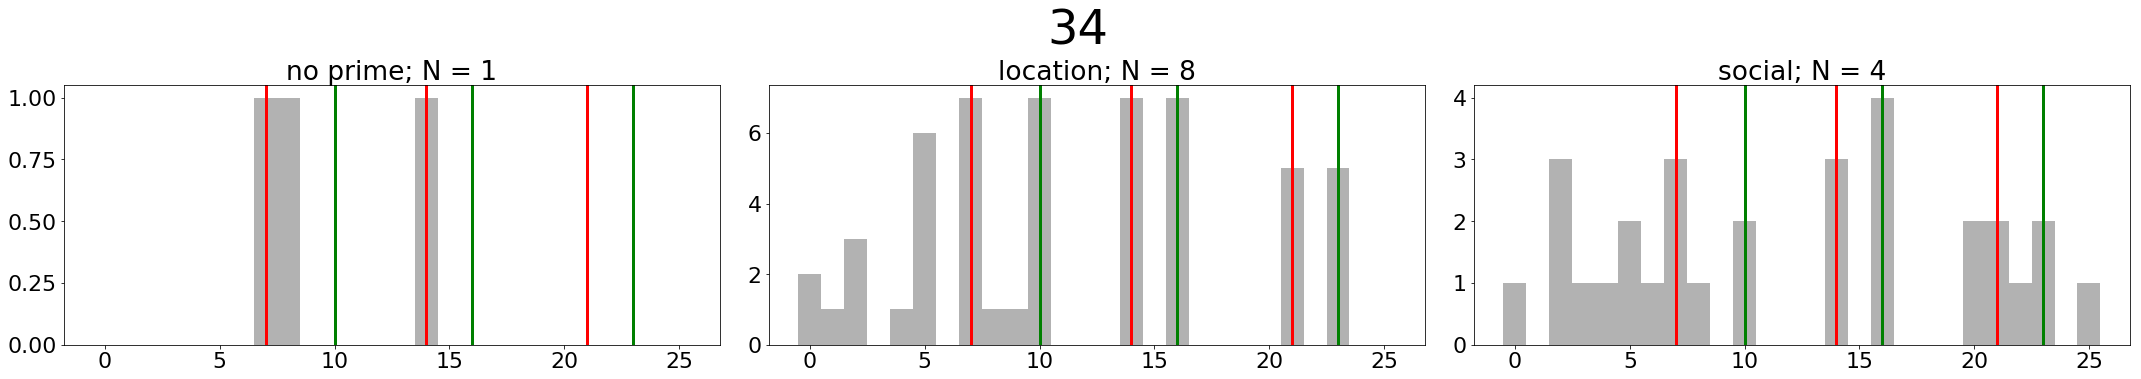

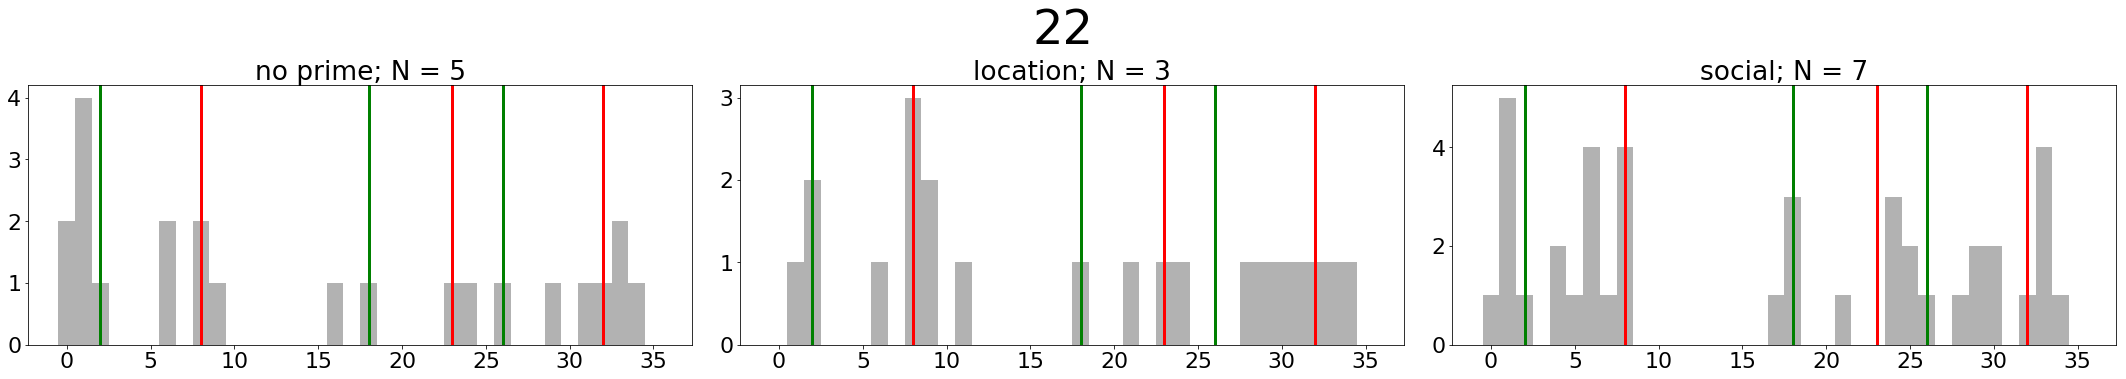

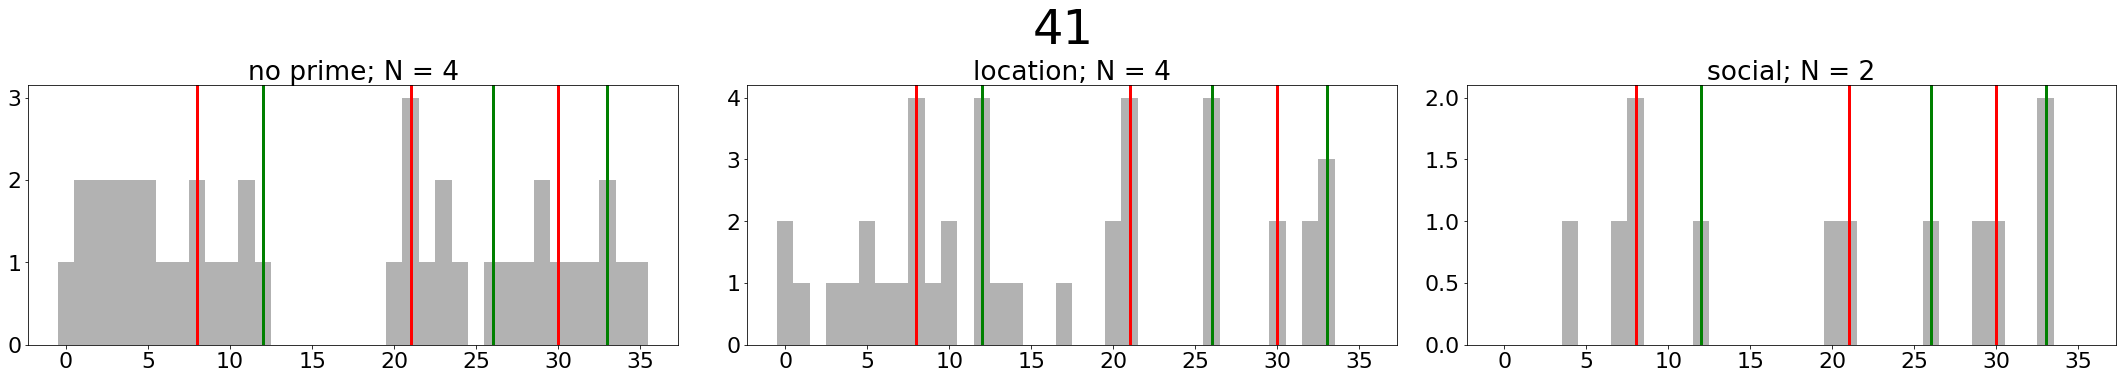

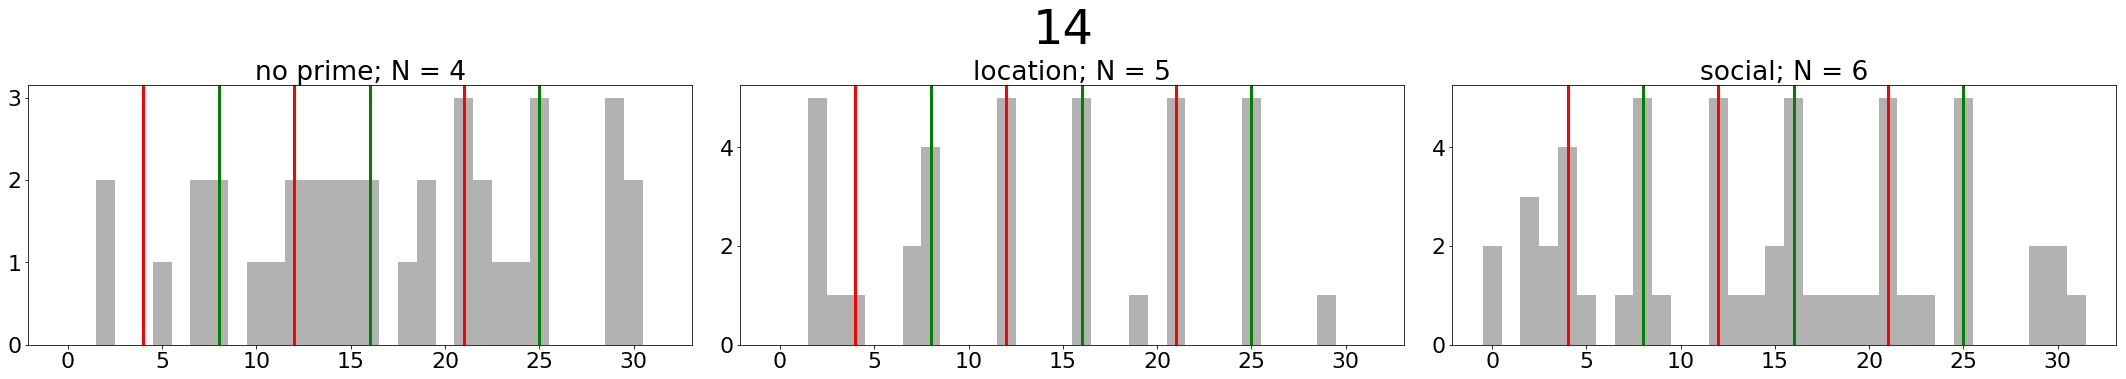

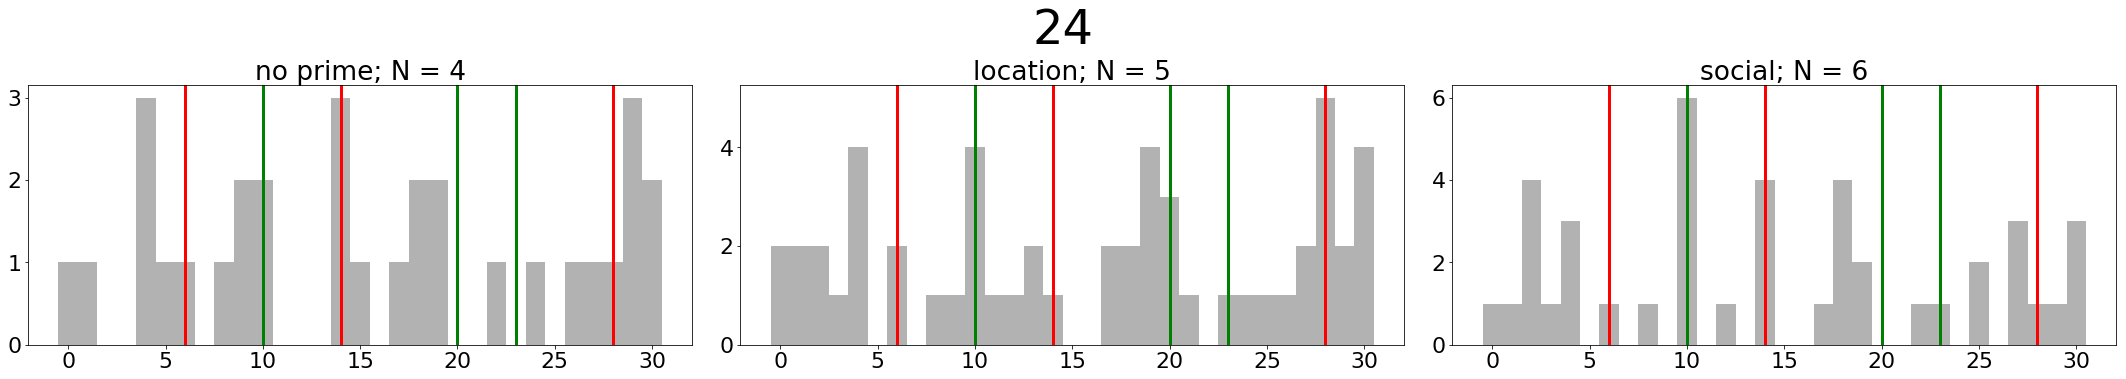

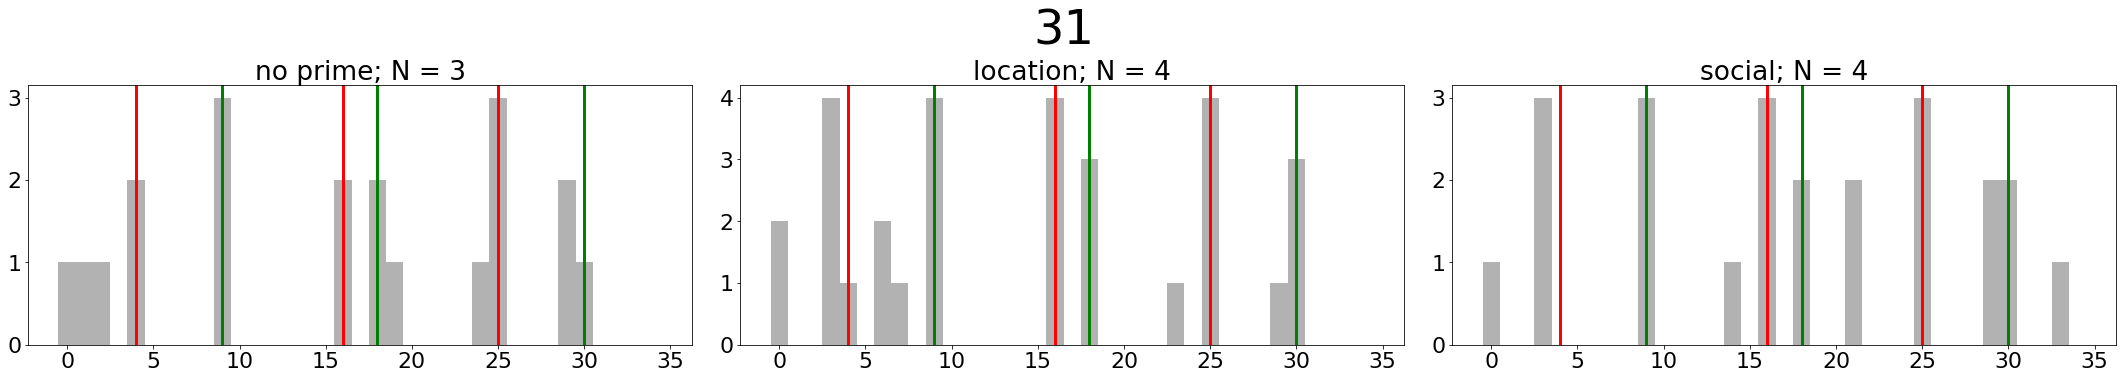

In [83]:
# Instantiating new dicts and iterating through all_keys summing row-wise
sum_keys_np = {}
sum_keys_l = {}
sum_keys_s = {}


list_keys = [none_keys, loc_keys, soc_keys]
list_sums = [sum_keys_np, sum_keys_l, sum_keys_s]


for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        these_keys = list_keys[i][key]
        list_sums[i][key] = np.sum(these_keys, axis = 1)
        
plt.rcParams.update({'font.size': 22})

# Plot each sum_keys array with loc boundaries

for key in sum_keys:
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(30,5))
    X = np.arange(len(sum_keys[key]))
    plt.rcParams.update({'font.size': 40})
    fig.suptitle(key, y=1.08)
    plt.rcParams.update({'font.size': 22})
    # ax1
    ax1.bar(X, sum_keys_np[key], color = 'k', width = 1, alpha=0.3)
    # Plotting the social boundaries
    ax1.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = 'g', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = 'g', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = 'g', linewidth=3.0)
    # Plotting the location boundaries
    ax1.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = 'r', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = 'r', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = 'r', linewidth=3.0)
    ax1.set_title('no prime; N = '+ str(sums[key][1]))
    
    # ax2
    ax2.bar(X, sum_keys_l[key], color = 'k', width = 1, alpha=0.3)
    # Plotting the social boundaries
    ax2.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = 'g', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = 'g', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = 'g', linewidth=3.0)
    # Plotting the location boundaries
    ax2.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = 'r', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = 'r', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = 'r', linewidth=3.0)
    ax2.set_title('location; N = '+ str(sums[key][2]))
    
    # ax3
    ax3.bar(X, sum_keys_s[key], color = 'k', width = 1, alpha=0.3)
    # Plotting the social boundaries
    ax3.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = 'g', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = 'g', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = 'g', linewidth=3.0)
    # Plotting the location boundaries
    ax3.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = 'r', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = 'r', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = 'r', linewidth=3.0)
    ax3.set_title('social; N = '+ str(sums[key][3]))
    fig.tight_layout()

